In [1]:
import pandas as pd
pd.set_option('display.max_colwidth', 200)
pd.set_option('display.max_columns', 30)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import missingno as msno
from scipy.stats import shapiro 
import phik
import pyarrow.parquet as pq

import warnings
warnings.filterwarnings("ignore")

# **1. Data Understanding**

## **1.1 Data Types**

In [3]:
def skim_dtype(df):
    df_info = pd.DataFrame({
        'attribute': df.columns.values,
        'data_type': df.dtypes.values,
        'n_unique': df.nunique().values,
        'sample_unique': [df[col].unique() for col in df.columns.values]
    }).reset_index(drop=True)
    print(f'rows, columns: {df.shape[0]}, {df.shape[1]}')
    return df_info

In [3]:
df = pq.read_table('../data/raw/yellow_tripdata_2023-01.parquet')
df = df.to_pandas()
skim_dtype(df)

rows, columns: 3066766, 19


,attribute,data_type,n_unique,sample_unique
0,VendorID,int64,2,"[2, 1]"
1,tpep_pickup_datetime,datetime64[ns],1610975,"[2023-01-01 00:32:10, 2023-01-01 00:55:08, 2023-01-01 00:25:04, 2023-01-01 00:03:48, 2023-01-01 00:10:29, 2023-01-01 00:50:34, 2023-01-01 00:09:22, 2023-01-01 00:27:12, 2023-01-01 00:21:44, 2023-0..."
2,tpep_dropoff_datetime,datetime64[ns],1611319,"[2023-01-01 00:40:36, 2023-01-01 01:01:27, 2023-01-01 00:37:49, 2023-01-01 00:13:25, 2023-01-01 00:21:19, 2023-01-01 01:02:52, 2023-01-01 00:19:49, 2023-01-01 00:49:56, 2023-01-01 00:36:40, 2023-0..."
3,passenger_count,float64,10,"[1.0, 0.0, 4.0, 2.0, 3.0, 5.0, 6.0, 8.0, 7.0, 9.0, nan]"
4,trip_distance,float64,4387,"[0.97, 1.1, 2.51, 1.9, 1.43, 1.84, 1.66, 11.7, 2.95, 3.01, 1.8, 7.3, 3.23, 11.43, 1.52, 2.23, 4.5, 1.2, 2.5, 1.4, 17.8, 0.8, 1.7, 5.7, 1.18, 2.42, 2.3, 0.7, 4.1, 9.5, 2.02, 2.17, 2.41, 0.6, 5.01, ..."
5,RatecodeID,float64,7,"[1.0, 2.0, 4.0, 99.0, 5.0, 3.0, 6.0, nan]"
6,store_and_fwd_flag,object,2,"[N, Y, None]"
7,PULocationID,int64,257,"[161, 43, 48, 138, 107, 239, 142, 164, 141, 234, 79, 33, 90, 113, 237, 143, 137, 132, 163, 68, 263, 170, 233, 236, 144, 229, 249, 162, 224, 151, 211, 148, 238, 231, 13, 262, 75, 264, 125, 186, 158..."
8,DOLocationID,int64,261,"[141, 237, 238, 7, 79, 137, 143, 200, 236, 107, 68, 264, 33, 61, 186, 48, 255, 239, 229, 116, 161, 164, 87, 232, 262, 75, 36, 263, 140, 246, 231, 170, 43, 233, 4, 162, 224, 145, 125, 24, 265, 163,..."
9,payment_type,int64,5,"[2, 1, 4, 3, 0]"


In [4]:
# mengubah nama kolom
df.rename(columns={
    'tpep_pickup_datetime': 'pickup_datetime',
    'tpep_dropoff_datetime': 'dropoff_datetime',
}, inplace=True)

# mengubah susunan kolom untuk mengelompokkan atribut tarif
df = df[['VendorID', 'pickup_datetime', 'dropoff_datetime',
       'store_and_fwd_flag', 'RatecodeID', 'PULocationID', 'DOLocationID',
       'passenger_count', 'trip_distance', 'fare_amount', 'extra', 'mta_tax',
       'tolls_amount', 'airport_fee', 'improvement_surcharge', 'congestion_surcharge',
       'tip_amount', 'total_amount', 'payment_type']]

In [5]:
df = df.astype({
    'pickup_datetime': 'datetime64[s]',
    'dropoff_datetime': 'datetime64[s]',
    'VendorID': 'object',
    'RatecodeID': 'object',
    'PULocationID': 'object',
    'DOLocationID': 'object',
    'passenger_count': 'object',
    'payment_type': 'object'
})

df.insert(loc=3, column='trip_duration_seconds', value=(df.dropoff_datetime - df.pickup_datetime).apply(lambda x: x.total_seconds()).astype('int64'))

In [6]:
df[df.RatecodeID == 99]

,VendorID,pickup_datetime,dropoff_datetime,trip_duration_seconds,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tolls_amount,airport_fee,improvement_surcharge,congestion_surcharge,tip_amount,total_amount,payment_type
329,1,2023-01-01 00:12:16,2023-01-01 00:26:14,838,N,99.0,74,248,1.0,4.4,24.5,0.0,0.5,6.55,0.0,1.0,0.0,0.0,32.55,1
4067,1,2023-01-01 00:34:52,2023-01-01 00:44:07,555,N,99.0,42,74,1.0,1.0,12.2,0.0,0.5,0.00,0.0,1.0,0.0,0.0,13.70,1
8744,1,2023-01-01 01:17:50,2023-01-01 02:02:32,2682,N,99.0,188,219,1.0,11.5,45.5,0.0,0.5,0.00,0.0,1.0,0.0,0.0,47.00,1
9254,1,2023-01-01 01:51:10,2023-01-01 02:19:45,1715,N,99.0,74,77,1.0,0.0,41.2,0.0,0.5,6.55,0.0,1.0,0.0,0.0,49.25,1
12769,1,2023-01-01 02:03:24,2023-01-01 03:04:37,3673,N,99.0,86,5,1.0,22.0,67.2,0.0,0.5,9.00,0.0,1.0,0.0,0.0,77.70,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2993723,1,2023-01-31 23:39:16,2023-02-01 00:19:40,2424,N,99.0,242,188,1.0,0.0,52.0,0.0,0.5,6.55,0.0,1.0,0.0,0.0,60.05,1
2993840,1,2023-01-31 23:14:47,2023-01-31 23:42:29,1662,N,99.0,90,136,1.0,0.0,31.7,0.0,0.5,0.00,0.0,1.0,0.0,0.0,33.20,1
2994503,1,2023-01-31 23:15:31,2023-01-31 23:22:39,428,N,99.0,42,41,1.0,0.9,12.2,0.0,0.5,0.00,0.0,1.0,0.0,0.0,13.70,1
2994504,1,2023-01-31 23:27:22,2023-01-31 23:58:15,1853,N,99.0,41,191,1.0,0.0,50.2,0.0,0.5,6.55,0.0,1.0,0.0,0.0,58.25,1


In [7]:
df.passenger_count = np.where(df.passenger_count > 6, 6, np.where(df.passenger_count == 0, 1, df.passenger_count))

## **1.2 Descriptive Statistics**

In [8]:
# menampilkan statistik deskriptif untuk data numerikal dan kategorikal
display(df.describe(), df.describe(include='object'))

,pickup_datetime,dropoff_datetime,trip_duration_seconds,trip_distance,fare_amount,extra,mta_tax,tolls_amount,airport_fee,improvement_surcharge,congestion_surcharge,tip_amount,total_amount
count,3066766,3066766,3.066766e+06,3.066766e+06,3.066766e+06,3.066766e+06,3.066766e+06,3.066766e+06,2.995023e+06,3.066766e+06,2.995023e+06,3.066766e+06,3.066766e+06
mean,2023-01-17 00:22:26,2023-01-17 00:38:06,9.401397e+02,3.847342e+00,1.836707e+01,1.537842e+00,4.882900e-01,5.184907e-01,1.074086e-01,9.820847e-01,2.274231e+00,3.367941e+00,2.702038e+01
min,2008-12-31 23:01:42,2009-01-01 14:29:11,-1.752000e+03,0.000000e+00,-9.000000e+02,-7.500000e+00,-5.000000e-01,-6.500000e+01,-1.250000e+00,-1.000000e+00,-2.500000e+00,-9.622000e+01,-7.510000e+02
25%,2023-01-09 16:21:57,2023-01-09 16:37:06,4.270000e+02,1.060000e+00,8.600000e+00,0.000000e+00,5.000000e-01,0.000000e+00,0.000000e+00,1.000000e+00,2.500000e+00,1.000000e+00,1.540000e+01
50%,2023-01-17 08:42:29,2023-01-17 08:58:30,6.910000e+02,1.800000e+00,1.280000e+01,1.000000e+00,5.000000e-01,0.000000e+00,0.000000e+00,1.000000e+00,2.500000e+00,2.720000e+00,2.016000e+01
75%,2023-01-24 16:26:27,2023-01-24 16:42:49,1.098000e+03,3.330000e+00,2.050000e+01,2.500000e+00,5.000000e-01,0.000000e+00,0.000000e+00,1.000000e+00,2.500000e+00,4.200000e+00,2.870000e+01
max,2023-02-01 00:56:53,2023-02-02 09:28:47,6.017510e+05,2.589281e+05,1.160100e+03,1.250000e+01,5.316000e+01,1.969900e+02,1.250000e+00,1.000000e+00,2.500000e+00,3.808000e+02,1.169400e+03
std,NaN,NaN,2.555661e+03,2.495838e+02,1.780782e+01,1.789592e+00,1.034641e-01,2.017579e+00,3.556511e-01,1.833529e-01,7.718454e-01,3.826759e+00,2.216359e+01


,VendorID,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,payment_type
count,3066766,2995023,2995023.0,3066766,3066766,2995023.0,3066766
unique,2,2,7.0,257,261,6.0,5
top,2,N,1.0,132,236,1.0,1
freq,2239399,2975020,2839305.0,160030,146348,2312564.0,2411462


## **1.3 Duplicated Data**

In [9]:
df[df.duplicated(keep=False)]

,VendorID,pickup_datetime,dropoff_datetime,trip_duration_seconds,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tolls_amount,airport_fee,improvement_surcharge,congestion_surcharge,tip_amount,total_amount,payment_type


In [10]:
df[df.duplicated(subset=['pickup_datetime', 'dropoff_datetime'], keep=False)]

,VendorID,pickup_datetime,dropoff_datetime,trip_duration_seconds,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tolls_amount,airport_fee,improvement_surcharge,congestion_surcharge,tip_amount,total_amount,payment_type
132,2,2023-01-01 00:28:29,2023-01-01 00:31:03,154,N,1.0,233,229,1.0,0.42,-5.10,-1.0,-0.5,0.0,0.0,-1.0,-2.5,0.00,-10.10,4
133,2,2023-01-01 00:28:29,2023-01-01 00:31:03,154,N,1.0,233,229,1.0,0.42,5.10,1.0,0.5,0.0,0.0,1.0,2.5,0.00,10.10,4
263,2,2023-01-01 00:20:18,2023-01-01 00:27:56,458,N,1.0,142,50,2.0,1.19,-9.30,-1.0,-0.5,0.0,0.0,-1.0,-2.5,0.00,-14.30,4
264,2,2023-01-01 00:20:18,2023-01-01 00:27:56,458,N,1.0,142,50,2.0,1.19,9.30,1.0,0.5,0.0,0.0,1.0,2.5,0.00,14.30,4
324,2,2023-01-01 00:52:22,2023-01-01 01:14:03,1301,N,1.0,238,167,1.0,4.89,-25.40,-1.0,-0.5,0.0,0.0,-1.0,-2.5,0.00,-30.40,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3064087,2,2023-01-30 18:31:34,2023-01-30 18:47:19,945,None,NaN,113,261,NaN,3.15,16.16,0.0,0.5,0.0,NaN,1.0,NaN,4.03,24.19,0
3064714,2,2023-01-31 07:44:00,2023-01-31 08:02:00,1080,None,NaN,142,262,NaN,2.69,16.42,0.0,0.5,0.0,NaN,1.0,NaN,3.06,23.48,0
3064772,2,2023-01-31 07:44:00,2023-01-31 08:02:00,1080,None,NaN,236,246,NaN,3.75,19.70,0.0,0.5,0.0,NaN,1.0,NaN,4.27,27.97,0
3065015,2,2023-01-31 08:47:00,2023-01-31 09:02:00,900,None,NaN,61,181,NaN,1.71,14.48,0.0,0.5,0.0,NaN,1.0,NaN,3.20,19.18,0


## **1.4 Missing Values**

In [11]:
def skim_null_values(df):
    df_info = pd.DataFrame({
        'attribute': df.columns.values,
        'data_type': df.dtypes.values,
        'n_null_value': df.isna().sum(),
        'percent_null_value': round(df.isna().sum()/len(df)*100, 2),
    }).reset_index(drop=True)
    print(f'rows, columns: {df.shape[0]}, {df.shape[1]}')
    return df_info

skim_null_values(df)

rows, columns: 3066766, 20


,attribute,data_type,n_null_value,percent_null_value
0,VendorID,object,0,0.00
1,pickup_datetime,datetime64[s],0,0.00
2,dropoff_datetime,datetime64[s],0,0.00
3,trip_duration_seconds,int64,0,0.00
4,store_and_fwd_flag,object,71743,2.34
5,RatecodeID,object,71743,2.34
6,PULocationID,object,0,0.00
7,DOLocationID,object,0,0.00
8,passenger_count,object,71743,2.34
9,trip_distance,float64,0,0.00


<Axes: >

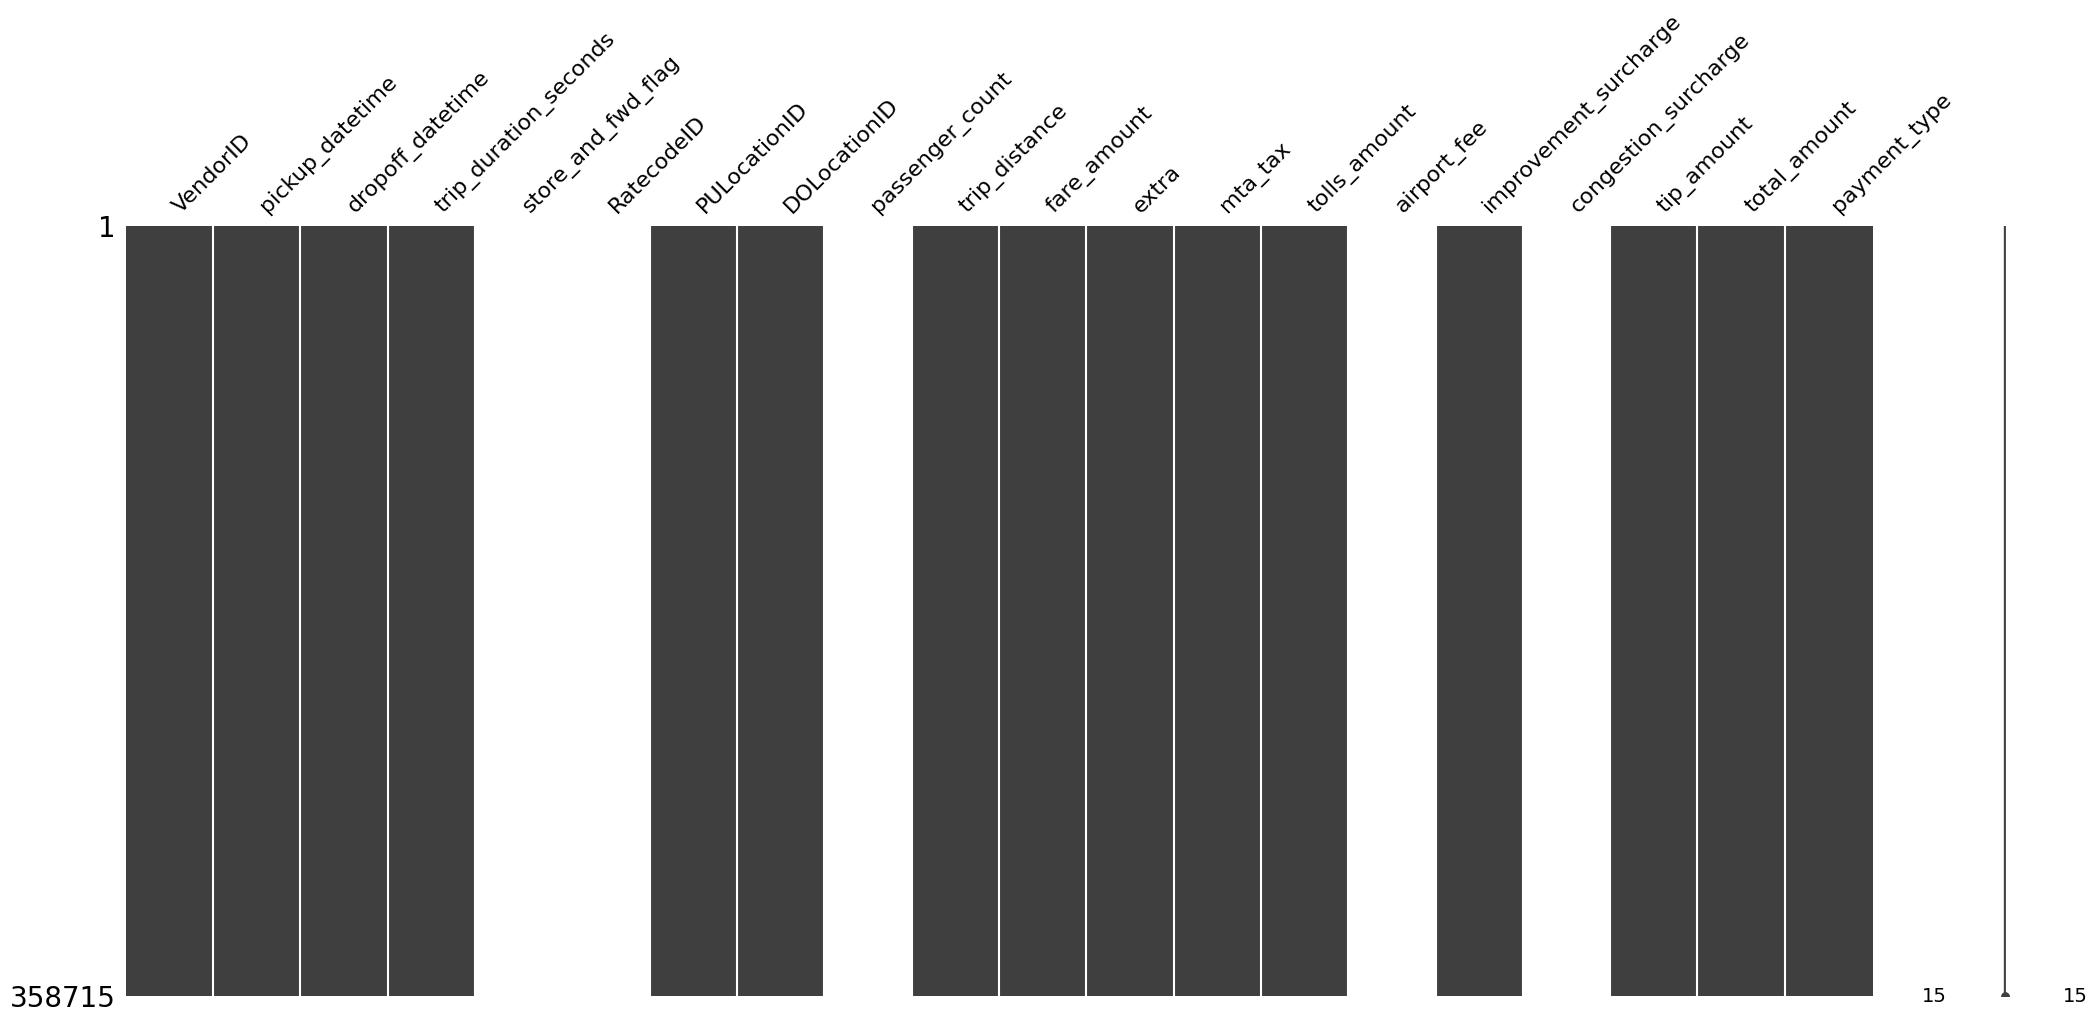

In [12]:
msno.matrix(df[df.isna().values])

## **1.5 Outliers**

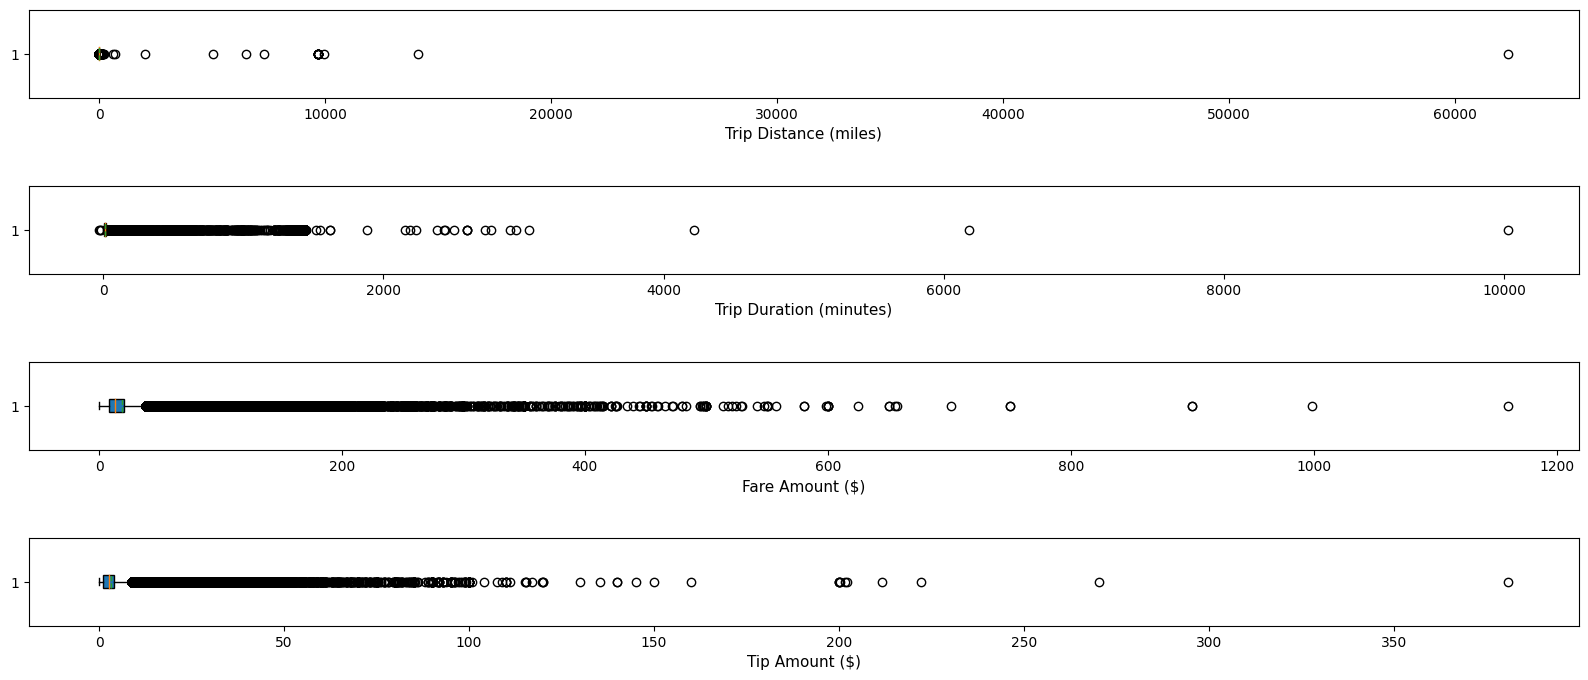

In [13]:
# exclude nan values
trip_distance = df.dropna().trip_distance
trip_duration_minutes = df.dropna().trip_duration_seconds.apply(lambda x: x/60)
fare_amount = df.dropna().fare_amount.apply(abs)
tip_amount = df.dropna().tip_amount.apply(abs)

fig, axes = plt.subplots(4, 1, figsize=(20, 8))
axes[0].boxplot(trip_distance, patch_artist=True, meanline=True, showmeans=True, vert=False)
axes[1].boxplot(trip_duration_minutes, patch_artist=True, meanline=True, showmeans=True, vert=False)
axes[2].boxplot(fare_amount, patch_artist=True, meanline=True, showmeans=True, vert=False)
axes[3].boxplot(tip_amount, patch_artist=True, meanline=True, showmeans=True, vert=False)

axes[0].set_xlabel("Trip Distance (miles)", fontsize=11)
axes[1].set_xlabel("Trip Duration (minutes)", fontsize=11)
axes[2].set_xlabel("Fare Amount ($)", fontsize=11)
axes[3].set_xlabel("Tip Amount ($)", fontsize=11)

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=1.5, hspace=1)
plt.show()

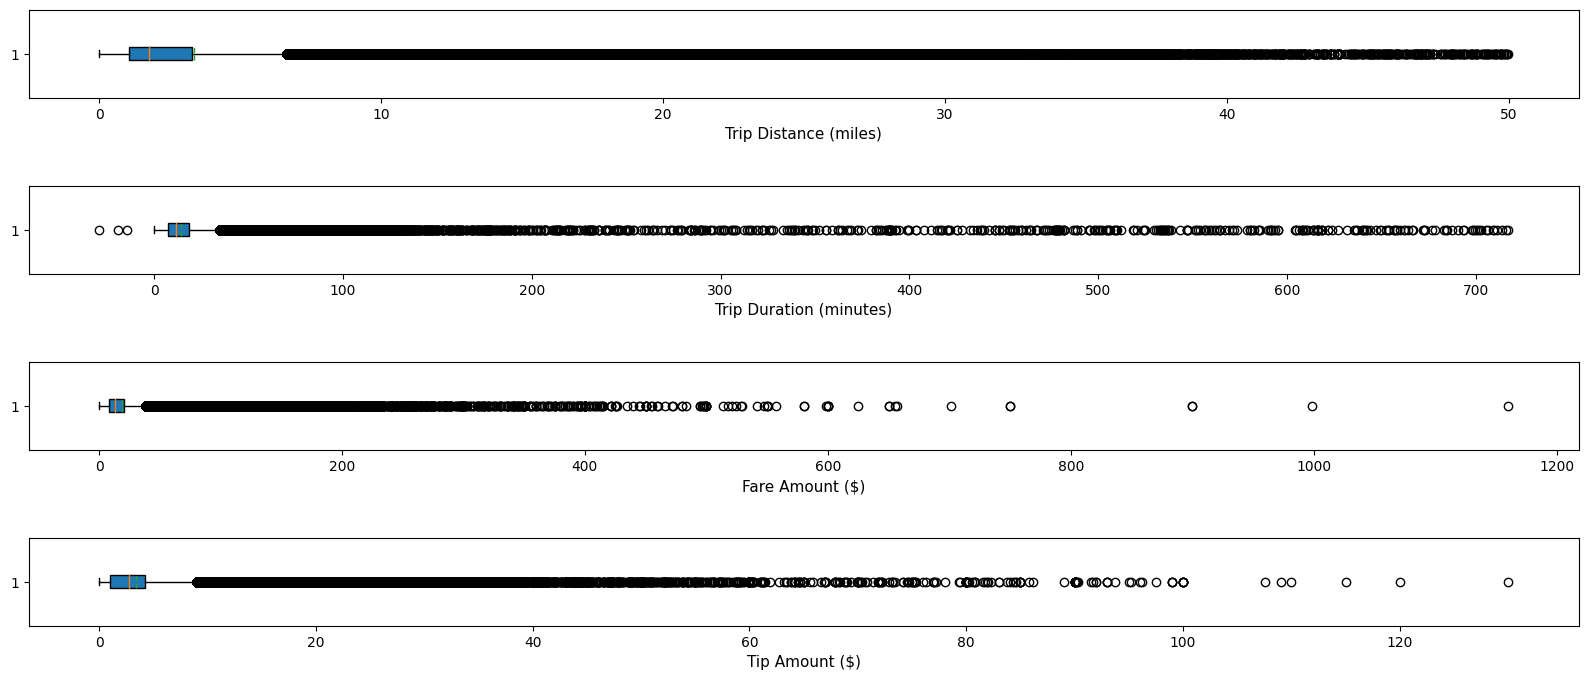

In [14]:
# memfilter jarak tempuh <= 50 mil
trip_distance = df[df.trip_distance <= 50].dropna().trip_distance
# memfilter durasi perjalanan <= 12 jam
trip_duration_minutes = df[df.trip_duration_seconds <= 12*3600].dropna().trip_duration_seconds.apply(lambda x: x/60)
fare_amount = df.dropna().fare_amount.apply(abs)
# memfilter jumlah tip <= 2 kali jumlah tarif perjalanan
tip_amount = df[df.tip_amount <= 2*df.fare_amount].dropna().tip_amount.apply(abs)

fig, axes = plt.subplots(4, 1, figsize=(20, 8))
axes[0].boxplot(trip_distance, patch_artist=True, meanline=True, showmeans=True, vert=False)
axes[1].boxplot(trip_duration_minutes, patch_artist=True, meanline=True, showmeans=True, vert=False)
axes[2].boxplot(fare_amount, patch_artist=True, meanline=True, showmeans=True, vert=False)
axes[3].boxplot(tip_amount, patch_artist=True, meanline=True, showmeans=True, vert=False)

axes[0].set_xlabel("Trip Distance (miles)", fontsize=11)
axes[1].set_xlabel("Trip Duration (minutes)", fontsize=11)
axes[2].set_xlabel("Fare Amount ($)", fontsize=11)
axes[3].set_xlabel("Tip Amount ($)", fontsize=11)

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=1.5, hspace=1)
plt.show()

# **2. Data Preparation**

## **2.1 Handling Duplicated Data**

In [15]:
print(f"n_data before removing duplicates: {len(df)}")
print(f"n_data with duplicates: {len(df[df.duplicated(subset=['pickup_datetime', 'dropoff_datetime'], keep='last')])}")

df.drop_duplicates(subset=['pickup_datetime', 'dropoff_datetime'], keep='last', inplace=True)
print(f"n_data after removing duplicates: {len(df)}")

n_data before removing duplicates: 3066766
n_data with duplicates: 26787
n_data after removing duplicates: 3039979


## **2.2 Handling Negative Values**

In [16]:
# melakukan absolut nilai negatif pada kolom-kolom tarif
df.loc[:,'fare_amount':'congestion_surcharge'] = df.loc[:,'fare_amount':'tip_amount'].apply(abs)

## **2.3 Dropping Attributes Not Used**

In [17]:
# drop kolom yang tidak akan digunakan dalam analisis
df.drop(columns=['VendorID', 'store_and_fwd_flag'], inplace=True)

## **2.4 Handling Pickup Datetime**

In [18]:
# menampilkan pickup di luar bulan Januari 2023
df[~((df.pickup_datetime.apply(lambda x: x.year) == 2023) & (df.pickup_datetime.apply(lambda x: x.month) == 1))]

,pickup_datetime,dropoff_datetime,trip_duration_seconds,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tolls_amount,airport_fee,improvement_surcharge,congestion_surcharge,tip_amount,total_amount,payment_type
80,2022-12-31 23:51:30,2022-12-31 23:56:06,276,1.0,141,140,1.0,0.86,6.5,1.0,0.5,0.00,0.00,1.0,2.5,2.00,13.50,1
567,2022-12-31 23:59:37,2023-01-01 00:07:28,471,1.0,142,151,1.0,2.38,12.1,1.0,0.5,0.00,0.00,1.0,2.5,4.28,21.38,1
761,2022-12-31 23:58:27,2023-01-01 00:02:21,234,1.0,229,237,1.0,0.49,5.8,1.0,0.5,0.00,0.00,1.0,2.5,0.08,10.88,1
900,2022-12-31 23:44:31,2022-12-31 23:48:47,256,1.0,233,162,1.0,0.52,5.8,1.0,0.5,0.00,0.00,1.0,2.5,2.16,12.96,1
1177,2022-12-31 23:59:25,2023-01-01 00:19:21,1196,1.0,141,68,2.0,3.65,19.1,1.0,0.5,0.00,0.00,1.0,2.5,7.23,31.33,1
2172,2022-12-31 14:24:54,2022-12-31 14:35:25,631,1.0,48,163,1.0,0.41,10.0,1.0,0.5,0.00,0.00,1.0,2.5,0.00,15.00,2
2173,2022-12-31 14:39:43,2022-12-31 14:43:37,234,1.0,163,162,1.0,0.54,5.8,1.0,0.5,0.00,0.00,1.0,2.5,2.16,12.96,1
2588,2022-12-31 23:58:08,2023-01-01 00:08:28,620,1.0,163,75,1.0,2.83,14.2,1.0,0.5,0.00,0.00,1.0,2.5,1.92,21.12,1
2696,2022-12-31 23:58:43,2023-01-01 00:09:39,656,1.0,161,234,3.0,2.11,12.8,1.0,0.5,0.00,0.00,1.0,2.5,0.00,17.80,2
2931,2022-12-31 22:02:51,2022-12-31 22:28:31,1540,1.0,79,238,1.0,7.78,35.9,1.0,0.5,0.00,0.00,1.0,2.5,8.18,49.08,1


In [19]:
print(f"n_data before removing irrelevant pickup time: {len(df)}")
print(f"n_data with irrelevant pickup time: {len(df[~((df.pickup_datetime.apply(lambda x: x.year) == 2023) & (df.pickup_datetime.apply(lambda x: x.month) == 1))])}")

# hanya mengambil data pickup di bulan Januari 2023
df = df[(df.pickup_datetime.apply(lambda x: x.year) == 2023) & (df.pickup_datetime.apply(lambda x: x.month) == 1)]
print(f"n_data after removing irrelevant pickup time: {len(df)}")

n_data before removing irrelevant pickup time: 3039979
n_data with irrelevant pickup time: 48
n_data after removing irrelevant pickup time: 3039931


## **2.5 Pickup, Drop-off Location ID**

In [20]:
df_zone = pd.read_csv('../data/raw/taxi_zone_lookup.csv')
display(skim_dtype(df_zone), df_zone.isna().sum(), df_zone[df_zone.service_zone.isna().values])

rows, columns: 265, 4


,attribute,data_type,n_unique,sample_unique
0,LocationID,int64,265,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, ..."
1,Borough,object,7,"[EWR, Queens, Bronx, Manhattan, Staten Island, Brooklyn, Unknown]"
2,Zone,object,261,"[Newark Airport, Jamaica Bay, Allerton/Pelham Gardens, Alphabet City, Arden Heights, Arrochar/Fort Wadsworth, Astoria, Astoria Park, Auburndale, Baisley Park, Bath Beach, Battery Park, Battery Par..."
3,service_zone,object,4,"[EWR, Boro Zone, Yellow Zone, Airports, nan]"


LocationID      0
Borough         0
Zone            1
service_zone    2
dtype: int64

,LocationID,Borough,Zone,service_zone
263,264,Unknown,NV,NaN
264,265,Unknown,NaN,NaN


In [21]:
print(f"n_data before removing unknown location name: {len(df)}")
print(f"n_data with unknown location name: {len(df[(df.PULocationID.isin([264,265])) | (df.DOLocationID.isin([264,265]))])}")

# hanya mengambil data pickup di bulan Januari 2023
df = df[(~df.PULocationID.isin([264,265])) & (~df.DOLocationID.isin([264,265]))]
print(f"n_data after removing unknown location name: {len(df)}")

n_data before removing unknown location name: 3039931
n_data with unknown location name: 57307
n_data after removing unknown location name: 2982624


In [22]:
df = df.merge(df_zone.set_index('LocationID'), how='left', left_on='PULocationID', right_index=True)
df.rename(columns={'Borough': 'pickup_borough',
                    'Zone': 'pickup_zone',
                    'service_zone': 'pickup_service_zone'}, inplace=True)

df = df.merge(df_zone.set_index('LocationID'), how='left', left_on='DOLocationID', right_index=True)
df.rename(columns={'Borough': 'dropoff_borough',
                    'Zone': 'dropoff_zone',
                    'service_zone': 'dropoff_service_zone'}, inplace=True)

df.drop(columns=['PULocationID', 'DOLocationID'], inplace=True)

## **2.6 Handling Missing Values**

<Axes: >

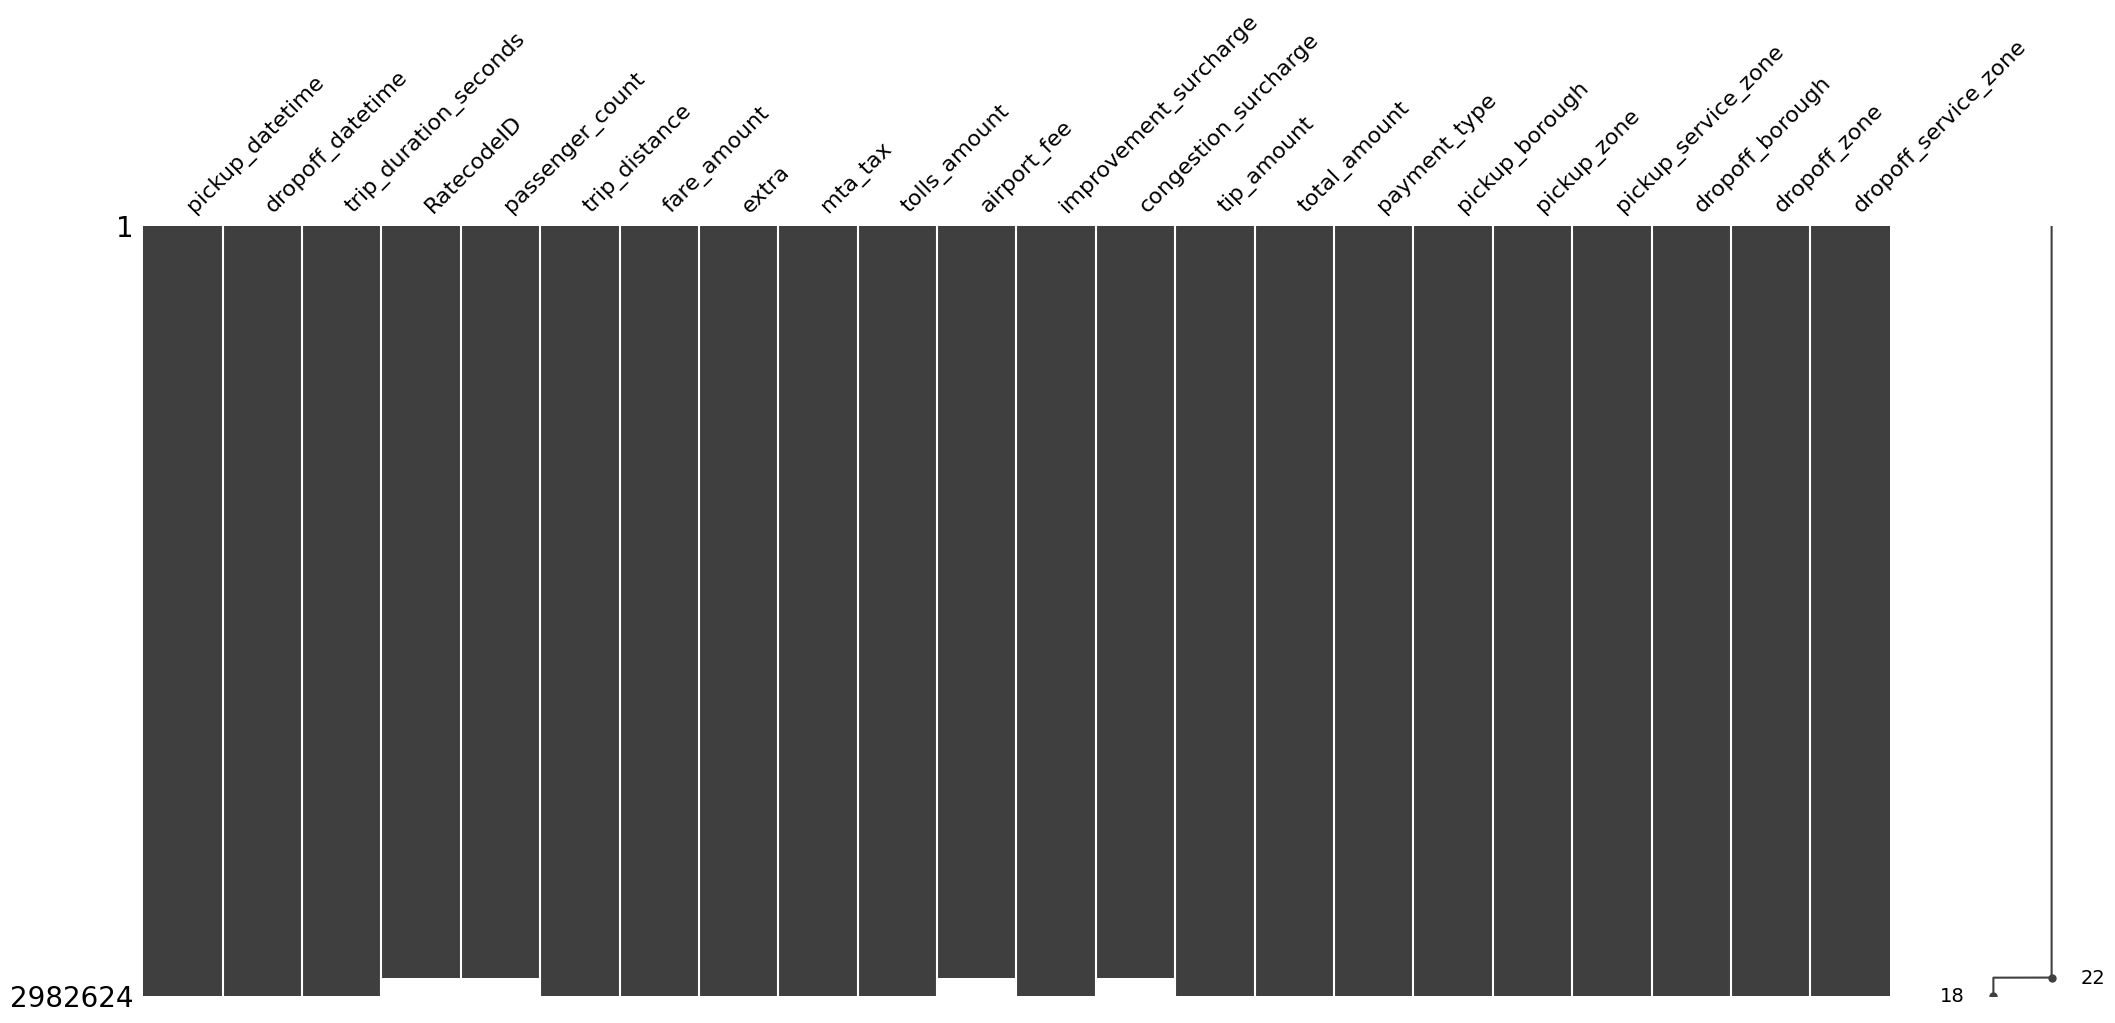

In [23]:
msno.matrix(df)

In [24]:
df.isna().sum()

pickup_datetime              0
dropoff_datetime             0
trip_duration_seconds        0
RatecodeID               70967
passenger_count          70967
trip_distance                0
fare_amount                  0
extra                        0
mta_tax                      0
tolls_amount                 0
airport_fee              70967
improvement_surcharge        0
congestion_surcharge     70967
tip_amount                   0
total_amount                 0
payment_type                 0
pickup_borough               0
pickup_zone                  0
pickup_service_zone          0
dropoff_borough              0
dropoff_zone                 0
dropoff_service_zone         0
dtype: int64

In [25]:
df_old = df.copy()

### 2.6.1 RatecodeID

In [26]:
# mengoreksi RatecodeID sesuai rute perjalanan
# tidak mengubah RatecodeID 5 dan 99
# RatecodeID 2: Perjalanan dari Manhattan ke JFK dan sebaliknya
# RatecodeID 3: Perjalanan ke Newark Airport
# selain itu merupakan RatecodeID 1

df['RatecodeID'] = np.where(df.RatecodeID.isin([5,99]), df.RatecodeID,\
    np.where(((df.pickup_borough == 'Manhattan') & (df.dropoff_zone == 'JFK Airport')) | ((df.pickup_zone == 'JFK Airport') & (df.dropoff_borough == 'Manhattan')), 2,\
    np.where(df.dropoff_zone == 'Newark Airport', 3, 1))).astype('int64').astype('object')

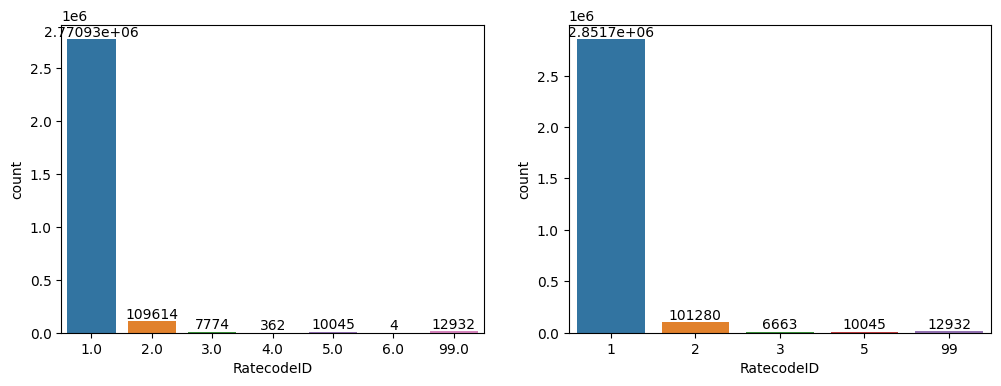

In [27]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
ax = sns.countplot(data=df_old, x='RatecodeID', ax=axes[0])
ax.bar_label(ax.containers[0])
ax = sns.countplot(data=df, x='RatecodeID', ax=axes[1])
ax.bar_label(ax.containers[0])
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)
plt.show();

In [28]:
# memisahkan data dengan dan tanpa missing values
df_na = df[df.passenger_count.isna().values].copy()
df_notna = df[~(df.passenger_count.isna().values)].copy()

### 2.6.2 Passenger Count

In [29]:
df_na.passenger_count.fillna(1, inplace=True)

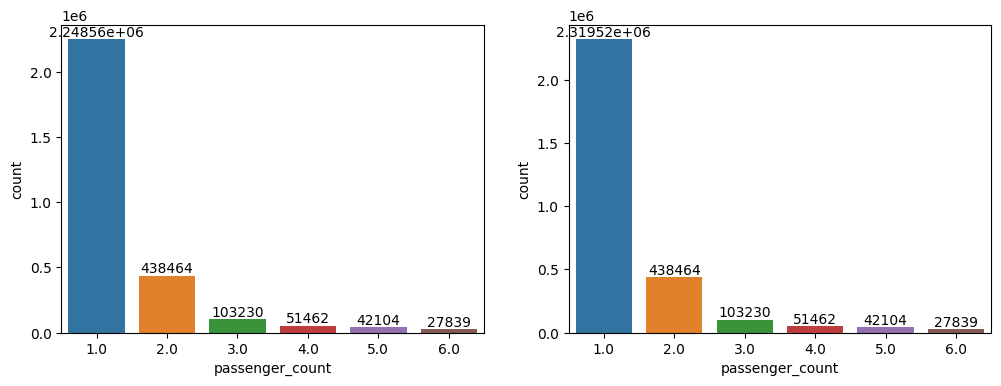

In [30]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
ax = sns.countplot(data=df_old, x='passenger_count', ax=axes[0])
ax.bar_label(ax.containers[0])
ax = sns.countplot(data=pd.concat([df_notna, df_na], axis=0).sort_index(), x='passenger_count', ax=axes[1])
ax.bar_label(ax.containers[0])
plt.show();

### 2.6.3 Congestion Surcharge

In [33]:
# membuat cross-tabulasi zona drop-off dan congestion surcharge
congestion_ct = pd.crosstab(df_notna.dropoff_zone, df_notna.congestion_surcharge, margins=True)
# mengurutkan frekuensi congestion surcharge dari nilai tertinggi
congestion_ct.sort_values(by=2.5, ascending=False)

congestion_surcharge,0.0,2.5,All
dropoff_zone,,,
All,205428,2706229,2911657
Upper East Side North,1082,140372,141454
Upper East Side South,139,128034,128173
Midtown Center,181,111537,111718
Times Sq/Theatre District,227,85891,86118
...,...,...,...
Jamaica Bay,19,2,21
Port Richmond,16,1,17
Governor's Island/Ellis Island/Liberty Island,0,1,1


In [34]:
p_congestion = {'p_congestion': (congestion_ct.iloc[:-1,1] / congestion_ct.iloc[-1,-1]) / (congestion_ct.iloc[:-1,2] / congestion_ct.iloc[-1,-1])}
p_congestion = pd.DataFrame(p_congestion)
p_congestion

,p_congestion
dropoff_zone,
Allerton/Pelham Gardens,0.217391
Alphabet City,0.996819
Arden Heights,0.092593
Arrochar/Fort Wadsworth,0.215190
Astoria,0.657442
...,...
Woodlawn/Wakefield,0.420749
Woodside,0.526721
World Trade Center,0.992419


In [35]:
import math
# menggabungkan peluang bersyarat dengan data missing values
df_na = df_na.merge(p_congestion, how='left', left_on='dropoff_zone', right_index=True)
# mengubah float nan menjadi np.nan
df_na.p_congestion = df_na.p_congestion.apply(lambda x: np.nan if math.isnan(x) else x)
# thresholding peluang > 0.5 dinyatakan macet (atau congestion surcharge ada nilainya, $2.75)
df_na.congestion_surcharge = np.where(df_na.p_congestion.isna().values, np.nan, np.where(df_na.p_congestion > 0.5, 2.75, 0))
# drop kolom p_congestion
df_na.drop(columns='p_congestion', inplace=True)

In [36]:
df_na.dropna(subset='congestion_surcharge', inplace=True)

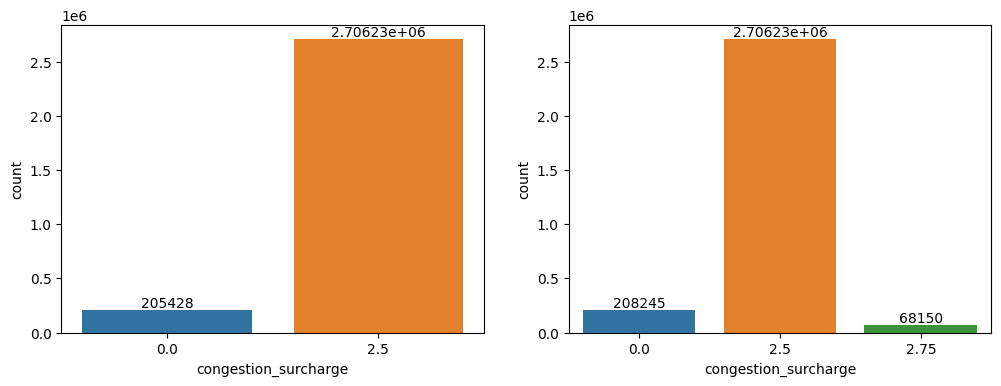

In [37]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
ax = sns.countplot(data=df_old, x='congestion_surcharge', ax=axes[0])
ax.bar_label(ax.containers[0])
ax = sns.countplot(data=pd.concat([df_notna, df_na], axis=0).sort_index(), x='congestion_surcharge', ax=axes[1])
ax.bar_label(ax.containers[0])
plt.show();

### 2.6.3 Airport Fee

In [38]:
# menggabungkan data dengan dan tanpa missing values
df = pd.concat([df_notna, df_na], axis=0).sort_index(ascending=True)

In [39]:
df.airport_fee = np.where(((df.pickup_zone.str.contains('Airport')) | (df.dropoff_zone.str.contains('Airport'))), 1.25, 0)

## **2.7 Handling Outliers**

### **2.7.1 Numerical, Continuous**

In [40]:
df_old = df.copy()

In [41]:
# longest distance between two arbitrary points in NYC & Google Maps
df.trip_distance = df.trip_distance.mask(df.trip_distance > 50)

# maksimal trip_speed untuk durasi lebih dari 2 jam adalah 11mph, kurang logis secara domain knowledge
df.trip_duration_seconds = df.trip_duration_seconds.mask(df.trip_duration_seconds > 2*3600)

# batas maksimal fare amount adalah maksimal tarif ke airport
df.fare_amount = df.fare_amount.mask(df.fare_amount > df[df.RatecodeID.isin([2,3])].fare_amount.max())

# batas maksimal tip adalah 2 kali fare_amount
df.tip_amount = df.tip_amount.mask((df.tip_amount > 2*df.fare_amount), 2*df.fare_amount)

In [42]:
df.isna().sum()

pickup_datetime             0
dropoff_datetime            0
trip_duration_seconds    3191
RatecodeID                  0
passenger_count             0
trip_distance              78
fare_amount                17
extra                       0
mta_tax                     0
tolls_amount                0
airport_fee                 0
improvement_surcharge       0
congestion_surcharge        0
tip_amount                  0
total_amount                0
payment_type                0
pickup_borough              0
pickup_zone                 0
pickup_service_zone         0
dropoff_borough             0
dropoff_zone                0
dropoff_service_zone        0
dtype: int64

In [43]:
idx_na = df[df.isna().values].index
idx_notna = df.index.difference(idx_na)

In [44]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

imp = IterativeImputer(max_iter=10, random_state=0)
cols = ['tip_amount', 'fare_amount','trip_distance', 'trip_duration_seconds']
df[cols] = imp.fit_transform(df[cols])

In [45]:
from scipy.stats import ks_2samp

stats, pvalue = ks_2samp(df_old.loc[idx_notna].trip_distance, df.trip_distance, alternative='two-sided')
print('p-value:', pvalue/2)

stats, pvalue = ks_2samp(df_old.loc[idx_notna].trip_duration_seconds, df.trip_duration_seconds, alternative='two-sided')
print('p-value:', pvalue/2)

stats, pvalue = ks_2samp(df_old.loc[idx_notna].fare_amount, df.fare_amount, alternative='two-sided')
print('p-value:', pvalue/2)

p-value: 0.4999999999998517
p-value: 0.49999469822871945
p-value: 0.49999999991426963


In [46]:
df.insert(loc=16, column='fees', value=df['extra'] + df['mta_tax'] + df['tolls_amount'] + df['airport_fee'] + df['improvement_surcharge'] + df['congestion_surcharge'])
df['total_amount'] = df['fare_amount'] + df['fees'] + df['tip_amount']

In [47]:
def distboxplot(data, bins, xticks, xlim, xlabel, unit, column=None):
    fig, axes = plt.subplots(
        nrows=2,
        ncols=1,
        figsize=(12,8),
        constrained_layout=True, 
        gridspec_kw={'height_ratios':[6,3]},
        sharex=True
    )
    sns.set_style("darkgrid")

    if column:
        sns.histplot(data=data, x=column, bins=bins, kde=True, ax=axes[0])
        axes[1].boxplot(data=data, x=column, patch_artist=True, meanline=True, showmeans=True, vert=False)
        # calculate central tendencies
        mean = data[column].mean()
        median = data[column].median()
        mad = abs(data[column] - data[column].median()).median()
    else:
        sns.histplot(data=data, bins=bins, kde=True, ax=axes[0])
        axes[1].boxplot(data, patch_artist=True, meanline=True, showmeans=True, vert=False)
        # calculate central tendencies
        mean = data.mean()
        median = data.median()
        mad = abs(data - data.median()).median()
    
    # create tendencies measurement lines
    axes[0].axvline(x=mean, color="limegreen", linestyle="--", label=f"mean: {mean:.2f} {unit}")
    axes[0].axvline(x=median, color="orange", linestyle="-", label=f"median: {median:.2f} {unit}")
    axes[0].axvline(x=median + mad, color="gold", linestyle="--", label=f"mad: {mad:.2f} {unit}")
    axes[0].axvline(x=median - mad, color="gold", linestyle="--")
    kde_x_0, kde_y_0 = axes[0].lines[0].get_data()
    axes[0].fill_between(
        kde_x_0, 
        kde_y_0, 
        where=(kde_x_0 > median - mad) & (kde_x_0 < median + mad), 
        color='gold', 
        alpha=0.2
    )

    axes[0].legend(prop={'size': 18})
    axes[0].set_xlim(xlim[0], xlim[1])

    axes[1].set_xlabel(xlabel, labelpad=15, fontsize=18)
    axes[1].set_xticks(xticks)
    axes[0].set_ylabel("Count", labelpad=15, fontsize=18)

    axes[0].tick_params(axis='both', labelsize=14)
    axes[1].tick_params(axis='x', labelsize=14)
    axes[1].set(yticklabels=[])

    plt.show();

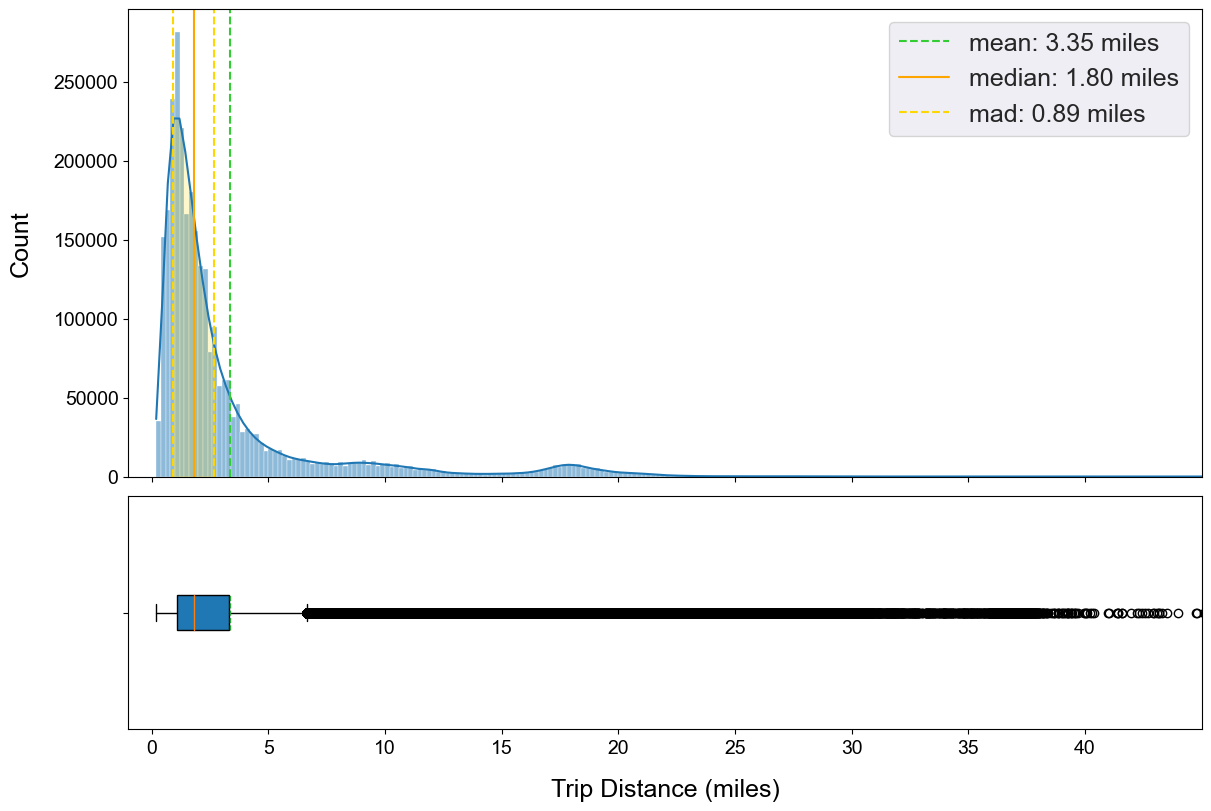

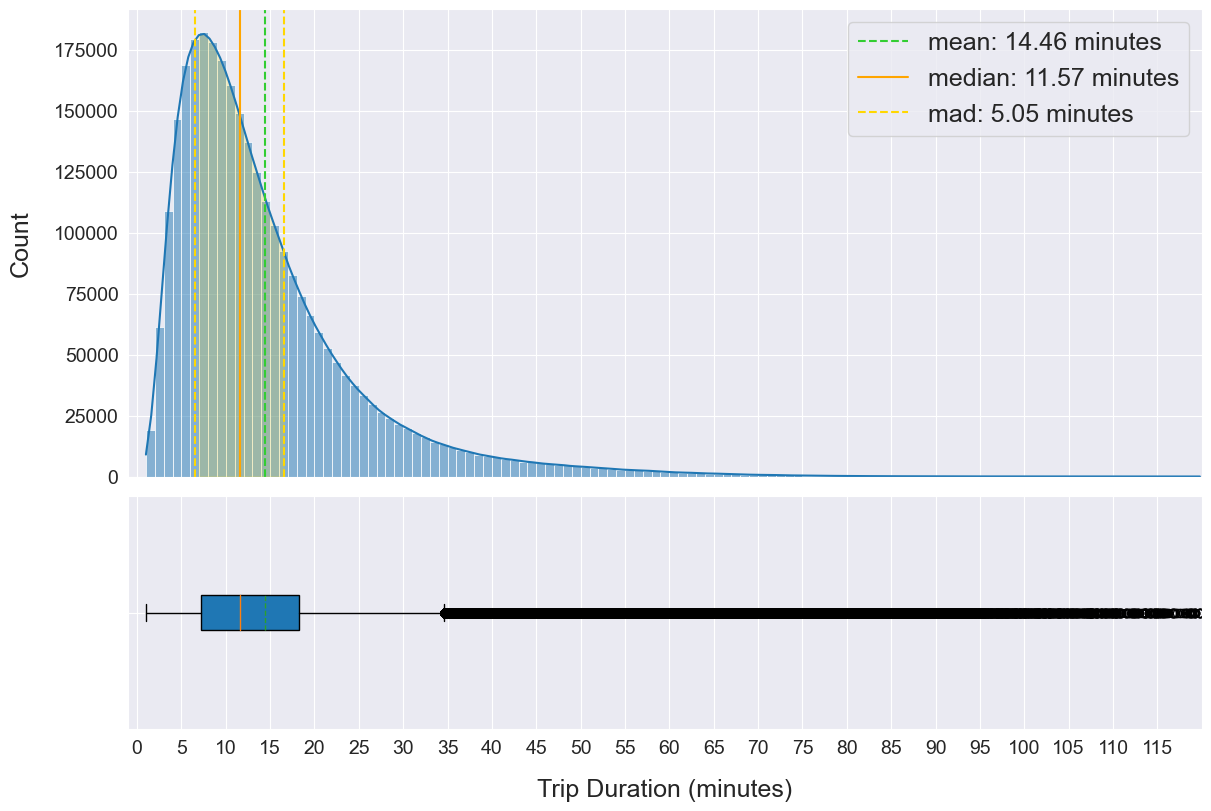

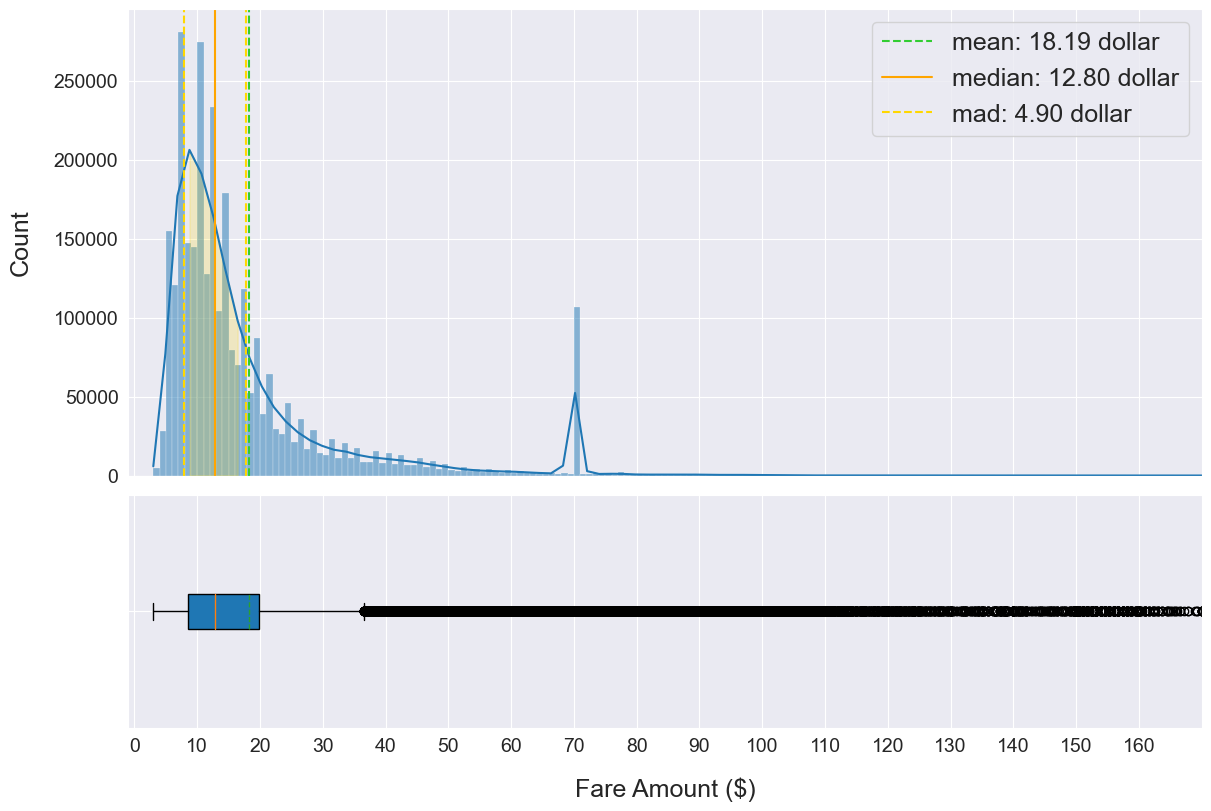

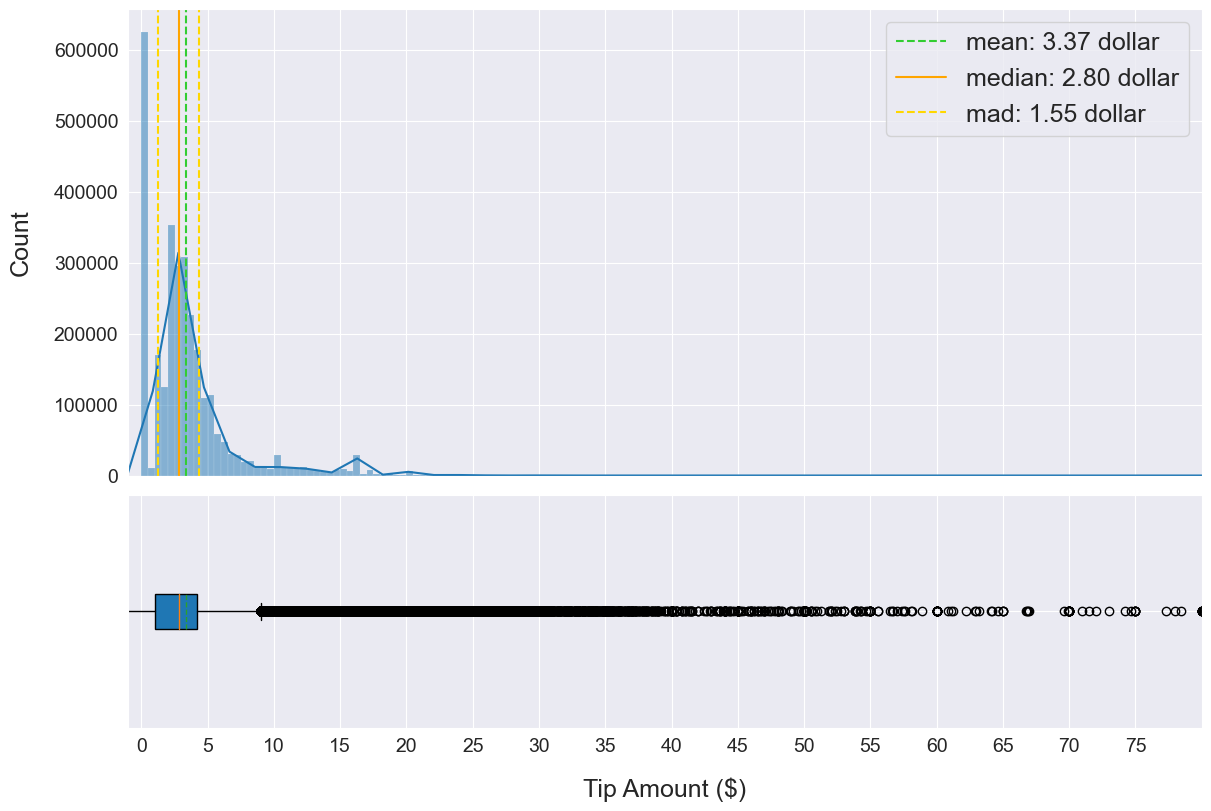

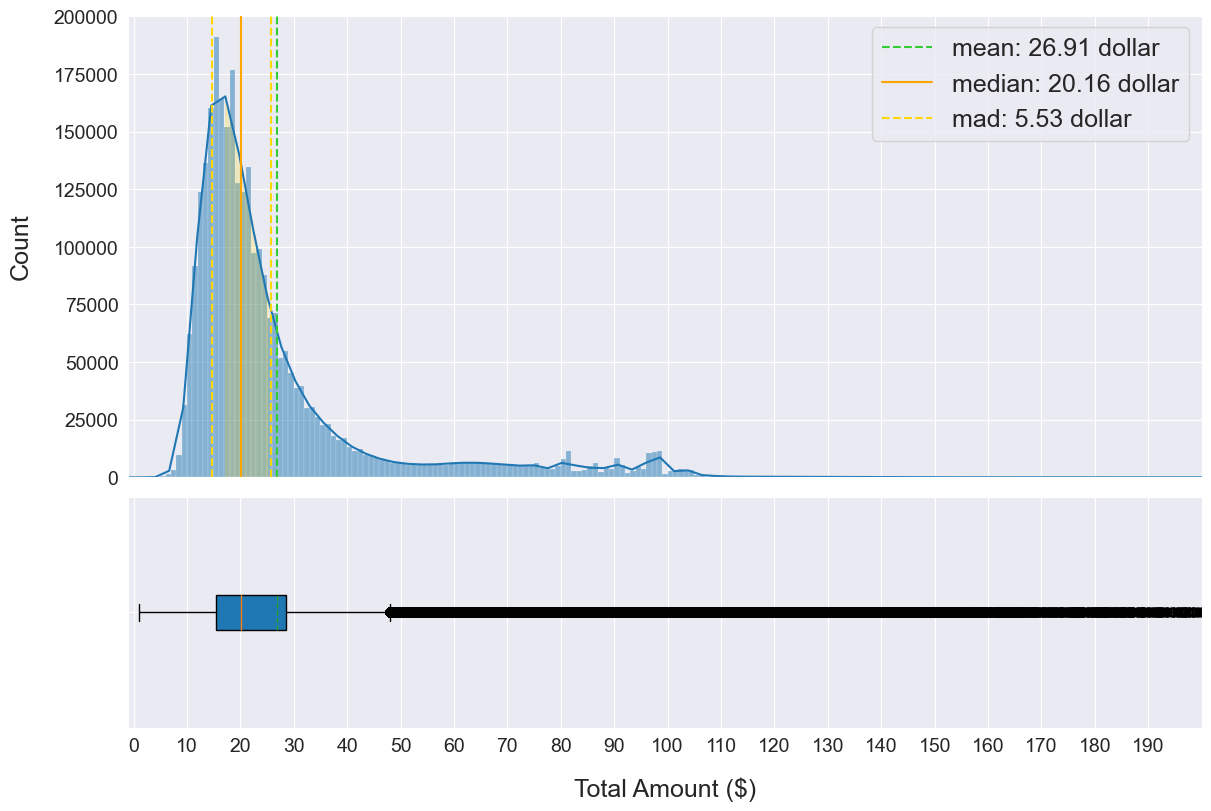

In [48]:
# limitasi analisis: >=0.2mil & >=60s & >= 3$
data = df_old[(df_old.trip_distance.between(0.2,50)) & (df_old.trip_duration_seconds.between(60,7200)) & (df_old.fare_amount.between(3,df[df.RatecodeID.isin([2,3])].fare_amount.max()))]

distboxplot(data=data, column='trip_distance', bins=np.arange(0,50,0.2),
            xticks=np.arange(0,45,5), xlim=[-1,45], xlabel='Trip Distance (miles)', unit='miles')
distboxplot(data=data.trip_duration_seconds.apply(lambda x: x/60), bins=np.arange(0,120,1),
            xticks=np.arange(0,120,5), xlim=[-1,120], xlabel='Trip Duration (minutes)', unit='minutes')
distboxplot(data=data, column='fare_amount', bins=np.arange(0,170,1),
            xticks=np.arange(0,170,10), xlim=[-1,170], xlabel='Fare Amount ($)', unit='dollar')
distboxplot(data=data, column='tip_amount', bins=np.arange(0,80,0.5),
            xticks=np.arange(0,80,5), xlim=[-1,80], xlabel='Tip Amount ($)', unit='dollar')
distboxplot(data=data, column='total_amount', bins=np.arange(0,200,1),
            xticks=np.arange(0,200,10), xlim=[-1,200], xlabel='Total Amount ($)', unit='dollar')

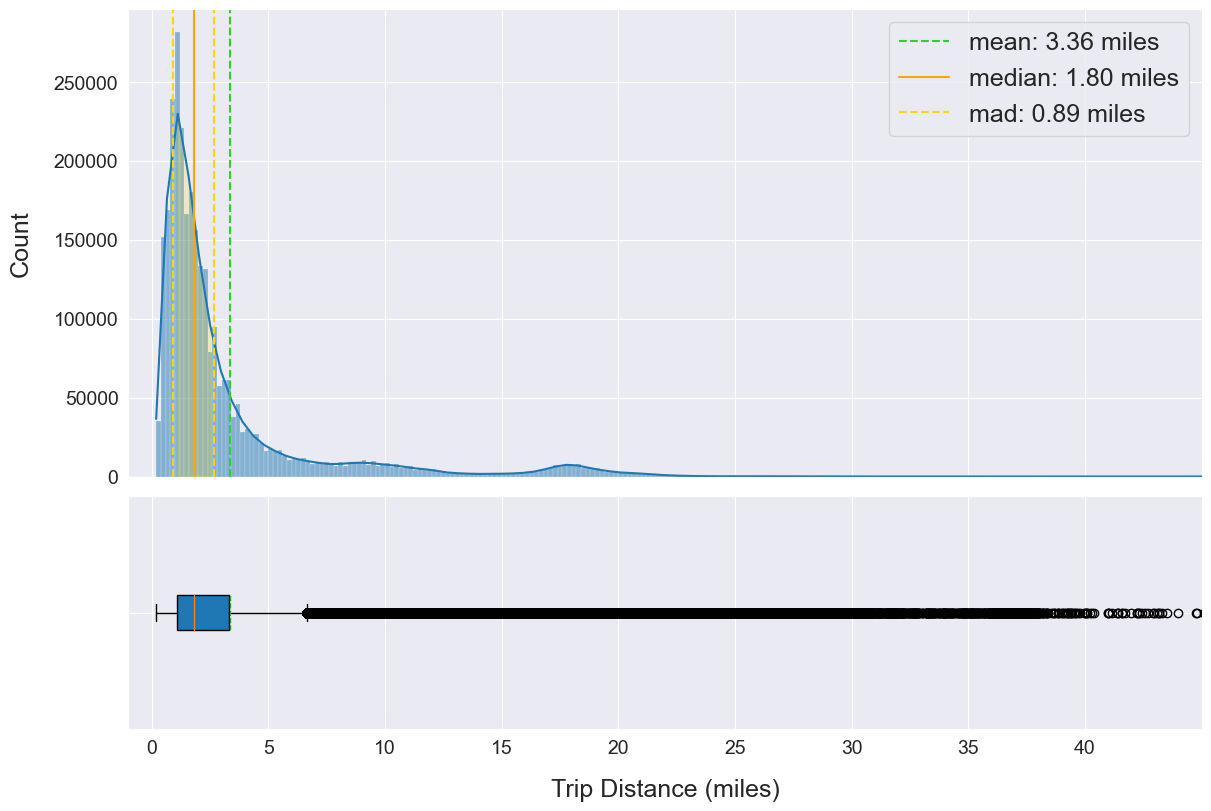

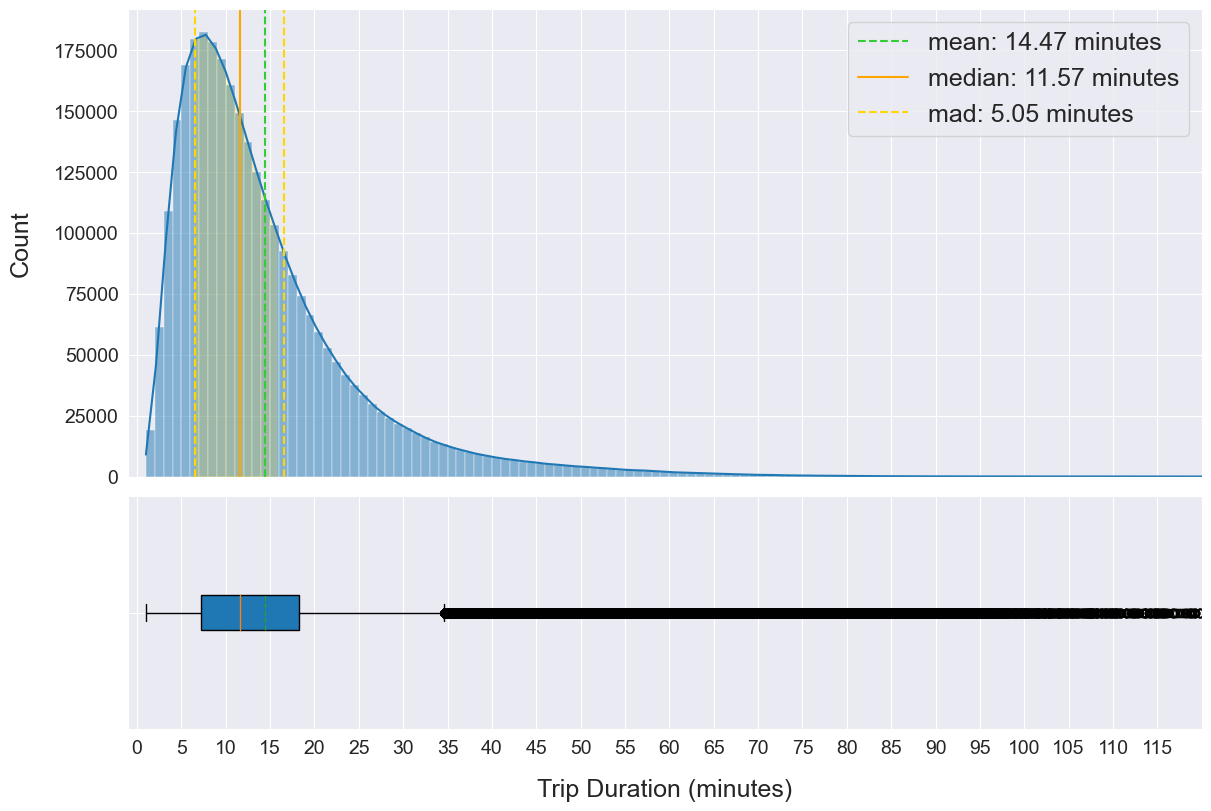

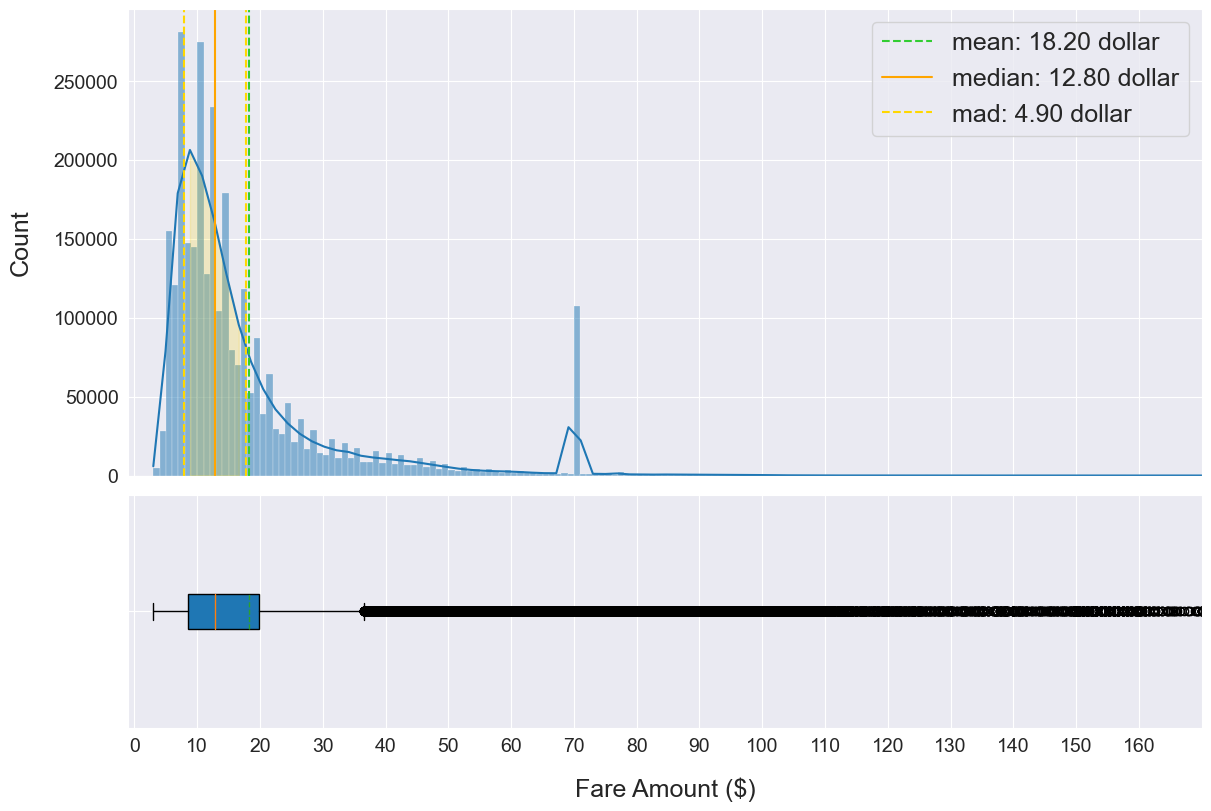

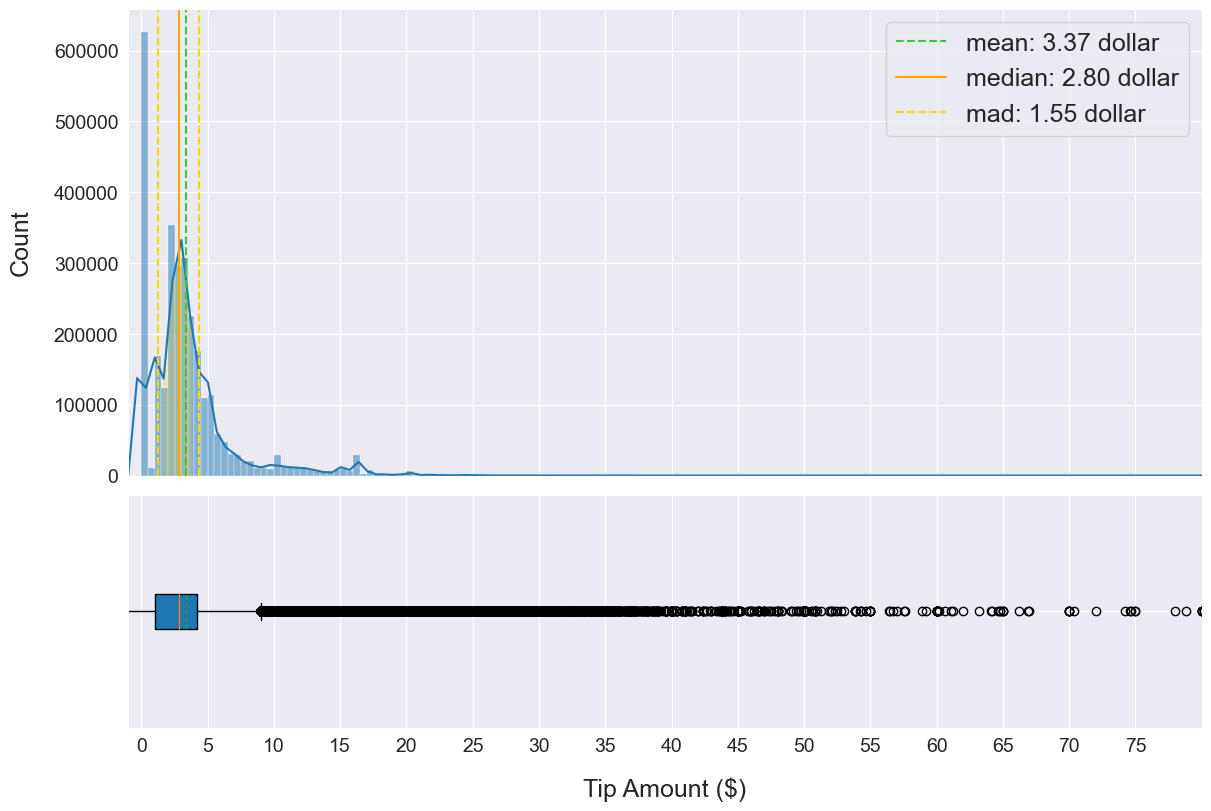

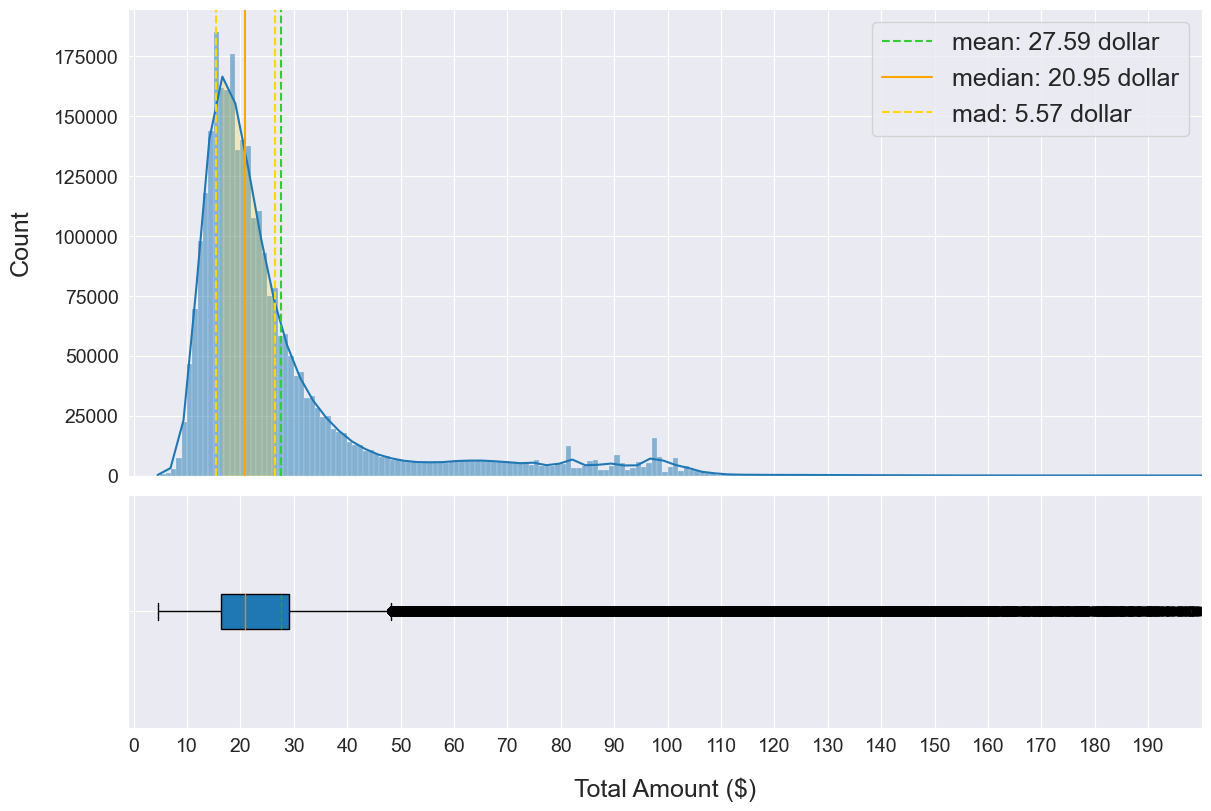

In [49]:
# limitasi analisis: >=0.2mil & >=60s & >= 3$
data = df[(df.trip_distance >= 0.2) & (df.trip_duration_seconds >= 60) & (df.fare_amount >= 3)]

distboxplot(data=data, column='trip_distance', bins=np.arange(0,50,0.2),
            xticks=np.arange(0,45,5), xlim=[-1,45], xlabel='Trip Distance (miles)', unit='miles')
distboxplot(data=data.trip_duration_seconds.apply(lambda x: x/60), bins=np.arange(0,120,1),
            xticks=np.arange(0,120,5), xlim=[-1,120], xlabel='Trip Duration (minutes)', unit='minutes')
distboxplot(data=data, column='fare_amount', bins=np.arange(0,170,1),
            xticks=np.arange(0,170,10), xlim=[-1,170], xlabel='Fare Amount ($)', unit='dollar')
distboxplot(data=data, column='tip_amount', bins=np.arange(0,80,0.5),
            xticks=np.arange(0,80,5), xlim=[-1,80], xlabel='Tip Amount ($)', unit='dollar')
distboxplot(data=data, column='total_amount', bins=np.arange(0,200,1),
            xticks=np.arange(0,200,10), xlim=[-1,200], xlabel='Total Amount ($)', unit='dollar')

In [50]:
from datetime import timedelta
df['dropoff_datetime'] = (df.pickup_datetime + df.trip_duration_seconds.apply(lambda x: timedelta(seconds=x))).astype('datetime64[s]')

### **2.7.2 Numerical, Discrete**

In [51]:
df['rate_category'] = np.where(df.RatecodeID == 1, 'standard', 'others').astype('object')
df['passenger_category'] = np.where(df.passenger_count == 1, 'single', 'multiple').astype('object')
df['congestion_category'] = np.where(df.congestion_surcharge == 2.75, 'yes', 'no').astype('object')
df['payment_category'] = np.where(df.payment_type == 1, 'card', np.where(df.payment_type == 2, 'cash', 'others')).astype('object')

In [52]:
skim_dtype(df)

rows, columns: 2982624, 27


,attribute,data_type,n_unique,sample_unique
0,pickup_datetime,datetime64[s],1595713,"[2023-01-01 00:32:10, 2023-01-01 00:55:08, 2023-01-01 00:25:04, 2023-01-01 00:03:48, 2023-01-01 00:10:29, 2023-01-01 00:50:34, 2023-01-01 00:09:22, 2023-01-01 00:27:12, 2023-01-01 00:21:44, 2023-0..."
1,dropoff_datetime,datetime64[s],1595666,"[2023-01-01 00:40:36, 2023-01-01 01:01:27, 2023-01-01 00:37:49, 2023-01-01 00:13:25, 2023-01-01 00:21:19, 2023-01-01 01:02:52, 2023-01-01 00:19:49, 2023-01-01 00:49:56, 2023-01-01 00:36:40, 2023-0..."
2,trip_duration_seconds,float64,8914,"[506.0, 379.0, 765.0, 577.0, 650.0, 738.0, 627.0, 1364.0, 896.0, 654.0, 524.0, 1781.0, 1194.0, 922.0, 546.0, 1348.0, 889.0, 360.0, 858.0, 393.0, 1830.0, 446.0, 612.0, 1155.0, 1169.0, 1034.0, 767.0..."
3,RatecodeID,object,5,"[1, 2, 99, 5, 3]"
4,passenger_count,object,6,"[1.0, 2.0, 3.0, 4.0, 5.0, 6.0]"
5,trip_distance,float64,3552,"[0.97, 1.1, 2.51, 1.9, 1.43, 1.84, 1.66, 11.7, 2.95, 3.01, 1.8, 3.23, 11.43, 1.52, 2.23, 4.5, 1.2, 2.5, 1.4, 17.8, 0.8, 1.7, 5.7, 1.18, 2.42, 2.3, 0.7, 4.1, 9.5, 2.02, 2.17, 2.41, 0.6, 5.01, 3.24,..."
6,fare_amount,float64,5862,"[9.3, 7.9, 14.9, 12.1, 11.4, 12.8, 45.7, 17.7, 26.1, 44.3, 10.0, 19.8, 20.5, 8.6, 15.6, 70.0, 26.8, 17.0, 13.5, 5.1, 19.1, 38.7, 14.2, 23.3, 16.3, 10.7, 5.8, 47.8, 30.3, 7.2, 21.9, 3.0, 48.5, 39.4..."
7,extra,float64,57,"[1.0, 7.25, 6.0, 3.5, 1.25, 0.5, 2.25, 0.0, 3.75, 3.0, 9.75, 2.5, 8.5, 1.14, 7.5, 5.0, 4.75, 6.25, 8.75, 2.72, 6.75, 9.25, 1.5, 11.25, 10.0, 3.7, 4.5, 7.0, 9.3, 3.05, 6.8, 8.97, 1.75, 0.02, 11.0, ..."
8,mta_tax,float64,9,"[0.5, 0.0, 0.8, 1.6, 4.0, 53.16, 0.3, 1.09, 1.05]"
9,tolls_amount,float64,622,"[0.0, 3.0, 6.55, 13.1, 8.36, 14.0, 5.0, 15.0, 19.65, 20.0, 11.75, 16.75, 14.75, 2.0, 9.0, 18.75, 2.5, 2.45, 18.25, 18.3, 19.0, 1.0, 23.5, 14.5, 19.55, 30.0, 16.05, 17.75, 21.75, 21.7, 22.5, 14.2, ..."


In [54]:
df.trip_duration_seconds = df.trip_duration_seconds.astype('int64')
df.trip_distance = round(df.trip_distance, 2)
df.total_amount = round(df.total_amount, 2)
df[['passenger_count', 'payment_type']] = df[['passenger_count', 'payment_type']].astype('int64').astype('object')
df[['extra', 'mta_tax', 'improvement_surcharge', 'congestion_surcharge']] = df[['extra', 'mta_tax', 'improvement_surcharge', 'congestion_surcharge']].astype('float64').astype('object')

In [55]:
skim_dtype(df)

rows, columns: 2982624, 27


,attribute,data_type,n_unique,sample_unique
0,pickup_datetime,datetime64[s],1595713,"[2023-01-01 00:32:10, 2023-01-01 00:55:08, 2023-01-01 00:25:04, 2023-01-01 00:03:48, 2023-01-01 00:10:29, 2023-01-01 00:50:34, 2023-01-01 00:09:22, 2023-01-01 00:27:12, 2023-01-01 00:21:44, 2023-0..."
1,dropoff_datetime,datetime64[s],1595666,"[2023-01-01 00:40:36, 2023-01-01 01:01:27, 2023-01-01 00:37:49, 2023-01-01 00:13:25, 2023-01-01 00:21:19, 2023-01-01 01:02:52, 2023-01-01 00:19:49, 2023-01-01 00:49:56, 2023-01-01 00:36:40, 2023-0..."
2,trip_duration_seconds,int64,5954,"[506, 379, 765, 577, 650, 738, 627, 1364, 896, 654, 524, 1781, 1194, 922, 546, 1348, 889, 360, 858, 393, 1830, 446, 612, 1155, 1169, 1034, 767, 170, 331, 921, 1645, 1955, 875, 492, 149, 1048, 1039..."
3,RatecodeID,object,5,"[1, 2, 99, 5, 3]"
4,passenger_count,object,6,"[1, 2, 3, 4, 5, 6]"
5,trip_distance,float64,3489,"[0.97, 1.1, 2.51, 1.9, 1.43, 1.84, 1.66, 11.7, 2.95, 3.01, 1.8, 3.23, 11.43, 1.52, 2.23, 4.5, 1.2, 2.5, 1.4, 17.8, 0.8, 1.7, 5.7, 1.18, 2.42, 2.3, 0.7, 4.1, 9.5, 2.02, 2.17, 2.41, 0.6, 5.01, 3.24,..."
6,fare_amount,float64,5862,"[9.3, 7.9, 14.9, 12.1, 11.4, 12.8, 45.7, 17.7, 26.1, 44.3, 10.0, 19.8, 20.5, 8.6, 15.6, 70.0, 26.8, 17.0, 13.5, 5.1, 19.1, 38.7, 14.2, 23.3, 16.3, 10.7, 5.8, 47.8, 30.3, 7.2, 21.9, 3.0, 48.5, 39.4..."
7,extra,object,57,"[1.0, 7.25, 6.0, 3.5, 1.25, 0.5, 2.25, 0.0, 3.75, 3.0, 9.75, 2.5, 8.5, 1.14, 7.5, 5.0, 4.75, 6.25, 8.75, 2.72, 6.75, 9.25, 1.5, 11.25, 10.0, 3.7, 4.5, 7.0, 9.3, 3.05, 6.8, 8.97, 1.75, 0.02, 11.0, ..."
8,mta_tax,object,9,"[0.5, 0.0, 0.8, 1.6, 4.0, 53.16, 0.3, 1.09, 1.05]"
9,tolls_amount,float64,622,"[0.0, 3.0, 6.55, 13.1, 8.36, 14.0, 5.0, 15.0, 19.65, 20.0, 11.75, 16.75, 14.75, 2.0, 9.0, 18.75, 2.5, 2.45, 18.25, 18.3, 19.0, 1.0, 23.5, 14.5, 19.55, 30.0, 16.05, 17.75, 21.75, 21.7, 22.5, 14.2, ..."


In [56]:
skim_null_values(df)

rows, columns: 2982624, 27


,attribute,data_type,n_null_value,percent_null_value
0,pickup_datetime,datetime64[s],0,0.0
1,dropoff_datetime,datetime64[s],0,0.0
2,trip_duration_seconds,int64,0,0.0
3,RatecodeID,object,0,0.0
4,passenger_count,object,0,0.0
5,trip_distance,float64,0,0.0
6,fare_amount,float64,0,0.0
7,extra,object,0,0.0
8,mta_tax,object,0,0.0
9,tolls_amount,float64,0,0.0


In [57]:
df.columns = df.columns.str.lower()
df.rename(columns={'ratecodeid': 'ratecode_id'}, inplace=True)

In [58]:
df['pickup_hour'] = df.pickup_datetime.apply(lambda x: x.hour).astype('object')
df['pickup_day'] = df.pickup_datetime.apply(lambda x: x.strftime("%a")).astype('object')
df['trip_distance_category'] = np.where(df.trip_distance.between(0,5), 'short', 'long').astype('object')
df['trip_duration_category'] = np.where(df.trip_duration_seconds.between(0,900), 'short', 'long').astype('object')

In [59]:
df = df[['pickup_datetime', 'dropoff_datetime', 'pickup_hour', 'pickup_day',
         'trip_duration_seconds', 'trip_duration_category', 'trip_distance', 'trip_distance_category',
         'congestion_category', 'fare_amount', 'fees', 'tip_amount', 'total_amount',
         'pickup_zone', 'dropoff_zone', 'pickup_borough', 'dropoff_borough', 'pickup_service_zone', 'dropoff_service_zone',
         'rate_category', 'passenger_category', 'payment_category']]

In [60]:
df = df[(df.trip_duration_seconds >= 0) & (df.trip_distance >= 0)]

In [61]:
display(df.describe(), df.describe(include='object'))

,pickup_datetime,dropoff_datetime,trip_duration_seconds,trip_distance,fare_amount,fees,tip_amount,total_amount
count,2982620,2982620,2.982620e+06,2.982620e+06,2.982620e+06,2.982620e+06,2.982620e+06,2.982620e+06
mean,2023-01-17 00:38:09,2023-01-17 00:52:32,8.621545e+02,3.299461e+00,1.827281e+01,5.998552e+00,3.343154e+00,2.761452e+01
min,2023-01-01 00:00:00,2023-01-01 00:03:28,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-5.780000e+00,0.000000e+00
25%,2023-01-09 16:36:14,2023-01-09 16:50:39,4.280000e+02,1.070000e+00,8.600000e+00,4.000000e+00,1.000000e+00,1.610000e+01
50%,2023-01-17 08:56:56,2023-01-17 09:12:17,6.890000e+02,1.790000e+00,1.280000e+01,5.000000e+00,2.740000e+00,2.090000e+01
75%,2023-01-24 16:29:55,2023-01-24 16:45:19,1.090000e+03,3.300000e+00,1.980000e+01,6.500000e+00,4.180000e+00,2.912000e+01
max,2023-01-31 23:59:59,2023-02-01 01:17:39,1.349500e+04,9.222000e+01,3.901000e+02,9.500000e+01,1.300000e+02,4.874400e+02
std,NaN,NaN,6.506296e+02,4.219463e+00,1.604392e+01,3.084739e+00,3.612845e+00,2.027340e+01


,pickup_hour,pickup_day,trip_duration_category,trip_distance_category,congestion_category,pickup_zone,dropoff_zone,pickup_borough,dropoff_borough,pickup_service_zone,dropoff_service_zone,rate_category,passenger_category,payment_category
count,2982620,2982620,2982620,2982620,2982620,2982620,2982620,2982620,2982620,2982620,2982620,2982620,2982620,2982620
unique,24,7,2,2,2,254,258,6,6,4,4,2,2,3
top,18,Tue,short,short,no,JFK Airport,Upper East Side North,Manhattan,Manhattan,Yellow Zone,Yellow Zone,standard,single,card
freq,210633,477861,1944993,2506034,2914470,151729,144720,2685775,2686706,2630907,2545268,2851703,2319521,2366422


In [62]:
df.sort_values(by='pickup_datetime', ascending=True, ignore_index=True, inplace=True)
display(df.index, df)

RangeIndex(start=0, stop=2982620, step=1)

,pickup_datetime,dropoff_datetime,pickup_hour,pickup_day,trip_duration_seconds,trip_duration_category,trip_distance,trip_distance_category,congestion_category,fare_amount,fees,tip_amount,total_amount,pickup_zone,dropoff_zone,pickup_borough,dropoff_borough,pickup_service_zone,dropoff_service_zone,rate_category,passenger_category,payment_category
0,2023-01-01 00:00:00,2023-01-01 00:08:00,0,Sun,480,short,1.53,short,yes,12.98,4.25,0.00,17.23,Central Harlem North,Central Harlem,Manhattan,Manhattan,Boro Zone,Boro Zone,standard,single,others
1,2023-01-01 00:00:05,2023-01-01 00:26:27,0,Sun,1582,long,1.32,short,no,21.90,5.00,0.00,26.90,West Village,Penn Station/Madison Sq West,Manhattan,Manhattan,Yellow Zone,Yellow Zone,standard,single,cash
2,2023-01-01 00:00:06,2023-01-01 00:05:44,0,Sun,338,short,1.70,short,no,9.30,5.00,0.00,14.30,Hudson Sq,East Chelsea,Manhattan,Manhattan,Yellow Zone,Yellow Zone,standard,single,cash
3,2023-01-01 00:00:08,2023-01-01 00:11:24,0,Sun,676,short,3.10,short,no,16.30,2.50,0.00,18.80,Central Harlem North,Washington Heights South,Manhattan,Manhattan,Boro Zone,Boro Zone,standard,single,cash
4,2023-01-01 00:00:09,2023-01-01 00:15:10,0,Sun,901,long,3.80,short,no,19.80,5.00,7.44,32.24,East Village,TriBeCa/Civic Center,Manhattan,Manhattan,Yellow Zone,Yellow Zone,standard,single,card
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2982615,2023-01-31 23:59:53,2023-02-01 00:02:02,23,Tue,129,short,0.91,short,no,5.80,5.00,1.00,11.80,Lenox Hill West,Yorkville West,Manhattan,Manhattan,Yellow Zone,Yellow Zone,standard,single,card
2982616,2023-01-31 23:59:54,2023-02-01 00:10:14,23,Tue,620,short,2.61,short,no,14.20,5.00,2.00,21.20,Yorkville West,Garment District,Manhattan,Manhattan,Yellow Zone,Yellow Zone,standard,single,card
2982617,2023-01-31 23:59:57,2023-02-01 00:06:29,23,Tue,392,short,3.04,short,no,13.50,3.75,0.00,17.25,JFK Airport,South Ozone Park,Queens,Queens,Airports,Boro Zone,standard,single,cash
2982618,2023-01-31 23:59:59,2023-02-01 00:05:46,23,Tue,347,short,0.69,short,no,7.20,5.00,2.44,14.64,Lower East Side,Lower East Side,Manhattan,Manhattan,Yellow Zone,Yellow Zone,standard,multiple,card


In [63]:
df.to_parquet('../data/processed/clean_yellow_taxi.parquet', index=False)

In [5]:
df = pq.read_table('../data/processed/clean_yellow_taxi.parquet')
df = df.to_pandas()
skim_dtype(df)

rows, columns: 2982620, 22


,attribute,data_type,n_unique,sample_unique
0,pickup_datetime,datetime64[ns],1595713,"[2023-01-01 00:00:00, 2023-01-01 00:00:05, 2023-01-01 00:00:06, 2023-01-01 00:00:08, 2023-01-01 00:00:09, 2023-01-01 00:00:13, 2023-01-01 00:00:18, 2023-01-01 00:00:22, 2023-01-01 00:00:35, 2023-0..."
1,dropoff_datetime,datetime64[ns],1595665,"[2023-01-01 00:08:00, 2023-01-01 00:26:27, 2023-01-01 00:05:44, 2023-01-01 00:11:24, 2023-01-01 00:15:10, 2023-01-01 00:12:52, 2023-01-01 00:09:34, 2023-01-01 00:26:23, 2023-01-01 00:25:12, 2023-0..."
2,pickup_hour,int64,24,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]"
3,pickup_day,object,7,"[Sun, Mon, Tue, Wed, Thu, Fri, Sat]"
4,trip_duration_seconds,int64,5951,"[480, 1582, 338, 676, 901, 759, 556, 1561, 1477, 225, 1105, 854, 1254, 966, 943, 1551, 1206, 1711, 350, 531, 1157, 573, 512, 2077, 539, 2291, 945, 295, 704, 1672, 2503, 1710, 316, 577, 1648, 582, ..."
5,trip_duration_category,object,2,"[short, long]"
6,trip_distance,float64,3488,"[1.53, 1.32, 1.7, 3.1, 3.8, 8.97, 2.1, 0.0, 17.51, 0.95, 5.07, 9.98, 3.87, 4.38, 1.68, 5.35, 10.58, 1.6, 1.4, 4.78, 1.9, 21.4, 1.76, 19.41, 3.12, 0.98, 1.73, 19.93, 7.49, 20.37, 1.28, 1.78, 20.2, ..."
7,trip_distance_category,object,2,"[short, long]"
8,congestion_category,object,2,"[yes, no]"
9,fare_amount,float64,5862,"[12.98, 21.9, 9.3, 16.3, 19.8, 34.5, 11.4, 29.2, 66.0, 6.5, 23.3, 38.0, 14.2, 21.2, 26.1, 45.0, 8.6, 10.7, 70.0, 18.4, 7.2, 12.1, 41.5, 13.52, 28.2, 20.13, 7.9, 27.5, 57.6, 56.9, 54.1, 32.4, 5.8, ..."


In [11]:
df = df[df.pickup_borough.isin(['Bronx', 'Brooklyn', 'Queens'])]

In [12]:
df.to_parquet('../data/processed/clean_yellow_taxi_sub.parquet', index=False)